# **Đồ án: Phân loại và đự đoán khả năng đơn hàng bị từ chối trong Thương mại điện tử**


<a id="background"></a>
# **1. Đặt vấn đề:**

- Bối cảnh nghiên cứu: Trong lĩnh vực thương mại điện tử (E-commerce), tỷ lệ đơn hàng bị từ chối hoặc hủy bỏ (Order Rejection) là một thách thức lớn ảnh hưởng trực tiếp đến doanh thu và chi phí vận hành. Việc phân tích hành vi khách hàng liên quan đến các quyết định này là cơ sở quan trọng để tối ưu hóa quy trình hậu cần.

- Câu hỏi nghiên cứu: Khả năng một đơn hàng sau khi đặt mua sẽ bị từ chối/hủy là bao nhiêu? Và yếu tố nào gây ra những sự từ chối/hủy này?


<a id="objectives"></a>
# **2.Mục tiêu nghiên cứu:**

- Ứng dụng và so sánh các thuật toán Học máy (Machine Learning) để xây dựng mô hình phân lớp có khả năng dự đoán chính xác trạng thái rủi ro (Bị từ chối/Hủy) của đơn hàng mới.

- Xác định và xếp hạng mức độ quan trọng của các đặc trưng ảnh hưởng đến kết quả dự báo


<a id="data_extraction"></a>
# **3. TRÍCH XUẤT DỮ LIỆU**
<a id="import_libraries"></a>
## **3.a. Import (Nạp) các thư viện liên quan**



In [1]:
!pip install -q scikit-learn==1.3.2

# Cài 'imbalanced-learn' bản 0.11.0 
!pip install -q imbalanced-learn==0.11.0

# Cài 'pandas' bản 2.0.3 
!pip install -q pandas==2.0.3

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from glob import glob
import warnings

# Thư viện cho Tiền xử lý và Cân bằng dữ liệu
from imblearn.over_sampling import SMOTENC # Sử dụng SMOTE cho dữ liệu hỗn hợp
from sklearn.preprocessing import OneHotEncoder, StandardScaler # Đổi sang StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Thư viện cho Mô hình hóa và Đánh giá
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, classification_report, accuracy_score
from sklearn import set_config

# Cấu hình hiển thị
sns.set()
set_config(display="diagram")
warnings.simplefilter(action="ignore", category="FutureWarning") # Ẩn các cảnh báo phiên bản

<a id="check_file_names"></a>
## **3.b. Kiểm tra tên file trong đường dẫn dataset**



In [3]:
# Sử dụng glob để tìm TẤT CẢ file . csv trong thư mục input
# Pattern: "/kaggle/input/unlock-profits-with-e-commerce-sales-data/*. csv"
# Tìm mọi file có đuôi .csv trong thư mục này
filepath_list = glob("/kaggle/input/unlock-profits-with-e-commerce-sales-data/*.csv")

# In ra danh sách các file tìm được (để kiểm tra)
print(f"Tên của tất cả {len(filepath_list)} file csv trong thư mục là: ")
for number, filepath_name in enumerate(filepath_list, start=1):
    # Cắt bỏ phần đường dẫn dài, chỉ lấy tên file
    # rsplit(sep='/', maxsplit=1): Cắt từ phải sang trái, chỉ cắt 1 lần
    print(f" {number}. {filepath_name. rsplit(sep='/', maxsplit=1)[1]}")

Tên của tất cả 7 file csv trong thư mục là: 
 1. Amazon Sale Report.csv
 2. Cloud Warehouse Compersion Chart.csv
 3. May-2022.csv
 4. P  L March 2021.csv
 5. International sale Report.csv
 6. Expense IIGF.csv
 7. Sale Report.csv


<a id="read_dataset_to_dataframe"></a>
## **3.c. Đọc dataset vào một dataframe pandas tạm thời**


In [4]:
# Đọc file CSV đầu tiên (filepath_list[0]) vào DataFrame
# - low_memory=False: Tắt cảnh báo khi đọc file lớn (tự động detect dtype)
dataframe = pd.read_csv(filepath_list[0], low_memory=False)

# Hiển thị thông tin tổng quan của DataFrame
# → Số dòng, số cột, kiểu dữ liệu, số giá trị non-null
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

<a id="data_transformation_wrangle"></a>
# 4. DATA TRANSFORMATION**
<a id="first_draft_wrangle"></a>
## 4.a. First Draft Wrangle Function
- Hàm này dùng để làm sạch sơ bộ (preliminary cleansing) dataframe và chưa phải là hàm làm sạch cuối cùng, sẽ cải tiển sau EDA

- Các bước:

    1. Chuẩn hóa tên cột (lowercase, xóa space, xóa dash)
    2. Xóa các cột không cần thiết
    3.  Điền giá trị NaN cho location data
    4. Chuẩn hóa tên bang (shipstate)
    5. Xóa dòng trùng lặp

In [5]:
def first_draft_wrangle(dataframe):
    
 # BƯỚC 1: Tạo bản sao (copy) để tránh thay đổi dataframe gốc
    df = dataframe.copy()
    
 # BƯỚC 2: Chuẩn hóa tên cột
    # Ví dụ: "Order ID" → "orderid", "ship-service-level" → "shipservicelevel"
    col = [element.lower(). replace(" ", "").replace("-", "") 
           for element in df.columns]
    df.columns = col
    
# BƯỚC 3: Xóa các cột "rác" (không cần cho phân tích)
    # - index: Cột index dư thừa
    # - date: Không phân tích time series
    # - fulfilledby: Dư thừa (có cột 'fulfilment' rồi)
    # - currency: Tất cả đều INR (Indian Rupees)
    # - unnamed:22: Cột rỗng (data entry error)
    # - promotionids: Quá nhiều giá trị unique (high cardinality)
    # - courierstatus: Không liên quan trực tiếp
    # - shipcountry: Tất cả đều India
    df.drop(["index", "date", "fulfilledby", "currency", "unnamed:22",
             "promotionids", "courierstatus", "shipcountry"],
            axis="columns", inplace=True)
    
# BƯỚC 4: Xử lý giá trị thiếu (NaN) cho location data
    # Điền "unknown" cho bang và thành phố bị thiếu
    df["shipstate"]. fillna("unknown", inplace=True)
    df["shipcity"].fillna("unknown", inplace=True)
    
    # Điền 0 cho postal code thiếu, sau đó chuyển sang object (categorical)
    df["shippostalcode"]. fillna(0, inplace=True)
    df["shippostalcode"] = df["shippostalcode"].astype(int). astype(object)
    
# BƯỚC 5: Chuẩn hóa tên bang (shipstate)
    # 5.1.  Viết hoa tất cả (để dễ so sánh)
    df["shipstate"] = df["shipstate"].str.upper()
    
    # 5.2. Gom các tên bị gõ sai/viết tắt về tên chuẩn
    # Ví dụ: "RJ" → "RAJASTHAN", "DELHI" → "NEW DELHI"
    df["shipstate"]. replace({
        "PONDICHERRY": "PUDUCHERRY",
        "RAJSHTHAN": "RAJASTHAN",    # Typo
        "RAJSTHAN": "RAJASTHAN",      # Typo
        "RJ": "RAJASTHAN",            # Abbreviation
        "PB": "PUNJAB",               # Abbreviation
        "PUNJAB/MOHALI/ZIRAKPUR": "PUNJAB",
        "ORISSA": "ODISHA",           # Old name
        "DELHI": "NEW DELHI",
        "NL": "UNKNOWN",              # Invalid code
        "APO": "UNKNOWN",             # Military address
        "AR": "UNKNOWN"               # Invalid
    }, inplace=True)
    
# BƯỚC 6: Xóa các dòng trùng lặp (nếu có)
    df.drop_duplicates(inplace=True)
    
# BƯỚC 7: Trả về DataFrame đã làm sạch
    return df

<a id="eda"></a>
## **4.b. Phân tích Khám phá Dữ liệu (EDA)**

<a id="preliminary_data_cleaning"></a>
### **4.b.i. Làm sạch dữ liệu sơ bộ**<br>
Sử dụng hàm first_draft_wrangle(), chúng ta đọc và lưu trữ dataset đã được làm sạch sơ bộ vào dataframe tên là "df".

In [6]:
df = first_draft_wrangle(dataframe)
#Kiểm tra kết quả sau khi làm sạch 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128969 entries, 0 to 128974
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   orderid           128969 non-null  object 
 1   status            128969 non-null  object 
 2   fulfilment        128969 non-null  object 
 3   saleschannel      128969 non-null  object 
 4   shipservicelevel  128969 non-null  object 
 5   style             128969 non-null  object 
 6   sku               128969 non-null  object 
 7   category          128969 non-null  object 
 8   size              128969 non-null  object 
 9   asin              128969 non-null  object 
 10  qty               128969 non-null  int64  
 11  amount            121177 non-null  float64
 12  shipcity          128969 non-null  object 
 13  shipstate         128969 non-null  object 
 14  shippostalcode    128969 non-null  object 
 15  b2b               128969 non-null  bool   
dtypes: bool(1), float64(1), i

<a id="orderid"></a>
### <br>**4.b.ii. Phân tích cột "orderid" (Mã đơn hàng).**<br>
**Mục đích:**
- Kiểm tra xem có bao nhiêu đơn hàng "mua 1 sản phẩm" vs "mua nhiều sản phẩm"
- Quyết định có nên giữ lại đơn hàng "nhiều sản phẩm" hay không

In [7]:

# TẠO DATAFRAME CHỨA CÁC DÒNG CÓ ORDERID LẶP LẠI
# - duplicated(keep=False): Đánh dấu TẤT CẢ các dòng có orderid lặp
#   (keep=False → không giữ dòng nào, đánh dấu hết)
# Ví dụ: orderid "ABC123" xuất hiện 3 lần → 3 dòng đều được đánh dấu True
orderid_repeat_rows = df[df["orderid"]. duplicated(keep=False)]

# ĐẾM SỐ LƯỢNG ORDERID (DUY NHẤT) BỊ LẶP
# nunique() = number of unique values
unique_orderid_repeat_count = orderid_repeat_rows["orderid"].nunique()

# ĐẾM TỔNG SỐ DÒNG (ROWS) BỊ CHIẾM BỞI CÁC ĐƠN HÀNG LẶP
orderid_repeat_rows_count = len(orderid_repeat_rows)

# ĐẾM SỐ DÒNG CỦA CÁC ĐƠN HÀNG "KHÔNG LẶP" (Mua 1 món)
# duplicated(keep=False) == False: Chỉ lấy các dòng orderid KHÔNG lặp
orderid_nonrepeat_rows = df[df["orderid"].duplicated(keep=False) == False]
orderid_nonrepeat_rows_count = len(orderid_nonrepeat_rows)

# IN KẾT QUẢ
print(f"1.  Số lượng orderid (duy nhất) mua nhiều sản phẩm: {unique_orderid_repeat_count}\n"
      f"2. Tổng số dòng của các orderid mua nhiều sản phẩm: {orderid_repeat_rows_count}\n"
      f"3. Số lượng orderid (duy nhất) mua một sản phẩm: {orderid_nonrepeat_rows_count}")

1.  Số lượng orderid (duy nhất) mua nhiều sản phẩm: 6840
2. Tổng số dòng của các orderid mua nhiều sản phẩm: 15431
3. Số lượng orderid (duy nhất) mua một sản phẩm: 113538


Sau đó tiến hành vẽ biểu đồ cột thể hiện tỷ lệ của hai loại đơn hàng này

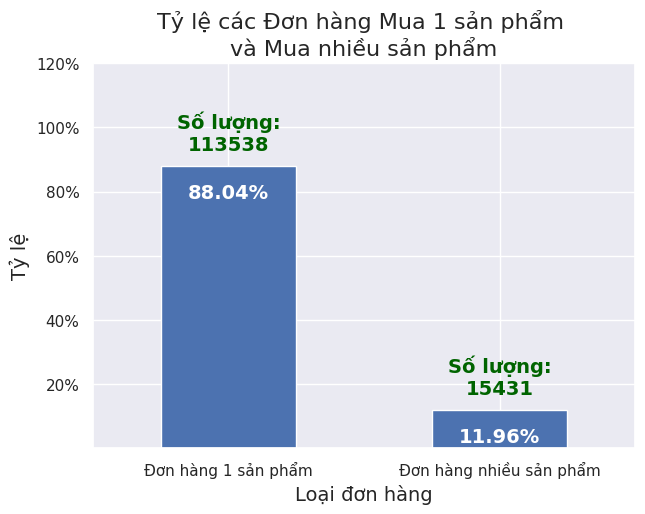

In [8]:
# Tạo figure và axes
fig, ax = plt.subplots(figsize=(7, 5))

# TÍNH TỶ LỆ % của 2 loại đơn hàng
# - value_counts(normalize=True): Đếm + tính tỷ lệ
# - *100: Chuyển thành %
# - round(... , 2): Làm tròn 2 số lẻ
orderid_repeat_rows = df[df["orderid"].duplicated(keep=False)]
unique_orderid_repeat_list = orderid_repeat_rows["orderid"].unique()
plot_dataseries = round(
    df["orderid"].isin(unique_orderid_repeat_list).value_counts(normalize=True) * 100, 
    2
)

# VẼ BIỂU ĐỒ CỘT
plot_dataseries.plot(kind="bar", ax=ax)

# TIÊU ĐỀ VÀ NHÃN
plt.title("Tỷ lệ các Đơn hàng Mua 1 sản phẩm \nvà Mua nhiều sản phẩm", fontsize=16)
plt.ylabel("Tỷ lệ", fontsize=14)
plt.xlabel("Loại đơn hàng", fontsize=14)
plt. xticks(ticks=plot_dataseries.index,
           labels=["Đơn hàng 1 sản phẩm", "Đơn hàng nhiều sản phẩm"], 
           rotation="horizontal")
plt.yticks(ticks=[20, 40, 60, 80, 100, 120], 
           labels=["20%", "40%", "60%", "80%", "100%", "120%"])

# THÊM NHÃN DỮ LIỆU (Data labels)
# Tạo nhãn % (ví dụ: "88. 03%")
data_label = plot_dataseries.astype(str).str.cat(np.full((2,), "%"), sep="")
# Tạo nhãn số đếm (ví dụ: "35000")
count_label = pd.Series(df["orderid"].isin(unique_orderid_repeat_list).value_counts()). astype("str")

# Vẽ nhãn % lên biểu đồ
for x, y in enumerate(plot_dataseries):
    plt.text(x, y-10, data_label[x], color="white",
             fontweight=700, fontsize=14, horizontalalignment="center")

# Vẽ nhãn số đếm lên biểu đồ
for x, y in enumerate(plot_dataseries):
    plt. text(x, y+5, ("Số lượng:\n" + count_label[x]), color="Darkgreen",
             fontweight=700, fontsize=14, horizontalalignment="center")

plt.show()

#### NHẬN XÉT:

**Quan sát:**
- 88.04% (gần 90%) dữ liệu là từ các đơn hàng "mua 1 sản phẩm" (single-product order)
- Chỉ có 11.96% là đơn hàng "mua nhiều sản phẩm" (multi-product order)

**Lý do:**
- "Multi-product orders introduce complexity: 
  - Có thể 1 sản phẩm bị reject, 1 sản phẩm OK
  - Khó xác định target rõ ràng (rejected hay không?)
  - Analysis riêng biệt cho multi-product orders recommended"

**Quyết định:**
**Xóa các đơn hàng "mua nhiều sản phẩm"**
- Lý do 1: Chiếm tỷ lệ nhỏ (chỉ 12%)
- Lý do 2: Khó xác định target (rejected hay không unclear)
- Lý do 3: Focus vào đa số (88%) để có kết quả rõ ràng hơn

**Sau đó xóa cột "orderid"** Vì sau khi chỉ giữ "đơn 1 món" → orderid không còn cần thiết (mỗi dòng = 1 đơn riêng biệt)

In [9]:
# Loại bỏ các đơn hàng có chứa nhiều sản phẩm (chỉ giữ lại đơn hàng mua 1 sản phẩm duy nhất)
df = df[df["orderid"].duplicated(keep = False) == False]
# drop redundant column "orderid"
# Xóa cột "orderid" vì nó đã trở nên dư thừa 
df.drop("orderid", axis = 1, inplace = True)
# Xem lại thông tin dataframe sau khi xử lý
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113538 entries, 0 to 128974
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   status            113538 non-null  object 
 1   fulfilment        113538 non-null  object 
 2   saleschannel      113538 non-null  object 
 3   shipservicelevel  113538 non-null  object 
 4   style             113538 non-null  object 
 5   sku               113538 non-null  object 
 6   category          113538 non-null  object 
 7   size              113538 non-null  object 
 8   asin              113538 non-null  object 
 9   qty               113538 non-null  int64  
 10  amount            106449 non-null  float64
 11  shipcity          113538 non-null  object 
 12  shipstate         113538 non-null  object 
 13  shippostalcode    113538 non-null  object 
 14  b2b               113538 non-null  bool   
dtypes: bool(1), float64(1), int64(1), object(12)
memory usage: 13.1+ MB


### **4.b.iii. Tạo cột "rejected" (Target Variable - Biến mục tiêu)**

**Mục đích:**
- Tạo biến mục tiêu nhị phân (binary target) cho bài toán classification
- Chuyển từ cột "status" (có nhiều giá trị) → cột "rejected" (chỉ có 0/1)
- Target Definition:
  - **1 (Rejected):** Các đơn hàng bị hủy/trả lại
  - **0 (Not Rejected):** Các đơn hàng giao thành công

**Phương pháp: Binary Encoding**
- **Bước 1:** Xác định các giá trị "status" rõ ràng (confirmed outcomes)
- **Bước 2:** Loại bỏ các status "lơ lửng" (Pending, Shipped without delivery confirmation)
- **Bước 3:** Encode: Cancelled', 'Shipped - Returned to Seller', 'Shipped - Rejected by Buyer', 'Shipped - Returning to Seller' → 1, 'Shipped - Delivered to Buyer' → 0

**Lý do loại bỏ status "lơ lửng":**
- "Pending": Chưa biết kết quả cuối cùng
- "Shipped": Có thể delivered, có thể returned → không chắc chắn
- → Giữ lại sẽ gây **label noise** (nhiễu nhãn) → giảm accuracy của model

In [10]:
# Lấy tất cả giá trị unique (duy nhất) trong cột "status"
# → Để xác định cách phân loại "Rejected" vs "Not Rejected"
print("Các giá trị unique trong cột 'status':")
print(df["status"].unique())

Các giá trị unique trong cột 'status':
['Cancelled' 'Shipped - Delivered to Buyer' 'Shipped'
 'Shipped - Returned to Seller' 'Shipped - Rejected by Buyer'
 'Shipped - Lost in Transit' 'Shipped - Out for Delivery'
 'Shipped - Returning to Seller' 'Shipped - Picked Up' 'Pending'
 'Pending - Waiting for Pick Up' 'Shipped - Damaged' 'Shipping']


In [11]:
# Xóa các dòng có status không rõ ràng
# 1. Định nghĩa các status có kết quả cuối cùng rõ ràng
known_value = ["Cancelled", 'Shipped - Returned to Seller','Shipped - Rejected by Buyer',
            'Shipped - Returning to Seller','Shipped - Delivered to Buyer']
# 2. Lọc dataframe, chỉ giữ lại các dòng có status nằm trong danh sách known_value
df = df[df["status"].isin(known_value)]    

# 3. TẠO CỘT "rejected" (Binary: 1=Rejected, 0=Not Rejected)
rejected = ["Cancelled", 'Shipped - Returned to Seller','Shipped - Rejected by Buyer',
            'Shipped - Returning to Seller']
# 4. Nếu status nằm trong danh sách "rejected" -> gán giá trị 1, ngược lại là 0
df["rejected"] = df["status"].isin(rejected).astype(int)    # đổi kiểu dữ liệu sang số nguyên (int) 

# 5. Xóa (drop) cột "status" gốc đi (vì đã có cột "rejected" mới)
df.drop("status",axis = "columns", inplace = True)

<br>Vẽ biểu đồ cột biểu diễn tỷ lệ của 2 status này

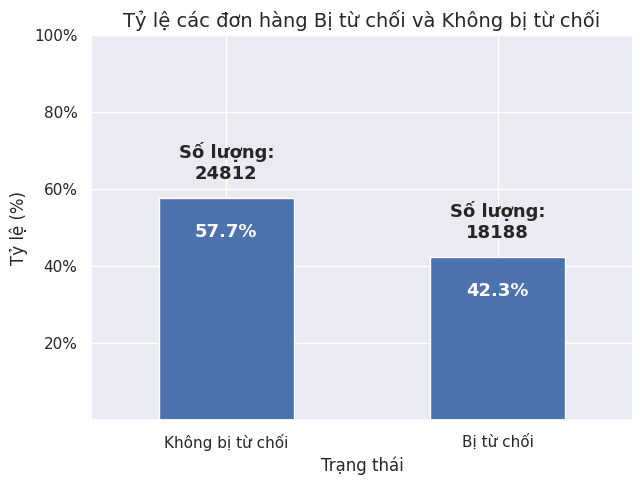

In [12]:
# vẽ biểu đồ cột dùng thư viện matplotlib
fig,ax = plt.subplots(figsize = (7,5))

# tính toán và lưu trữ tỷ lệ % của 2 lớp (0 và 1) vào một pandas.Series
plot_dataseries = round(df["rejected"].value_counts(normalize = True)*100,2)

# vẽ biểu đồ cột
plot_dataseries.plot(kind = "bar",ax =ax)
# Đặt Tiêu đề và Nhãn 
plt.title("Tỷ lệ các đơn hàng Bị từ chối và Không bị từ chối", fontsize = 14)
plt.ylabel("Tỷ lệ (%)", fontsize = 12)
plt.xlabel("Trạng thái", fontsize = 12)
plt.xticks(ticks = range(len(plot_dataseries)),
           labels = ["Không bị từ chối", "Bị từ chối"], rotation = "horizontal") 
plt.yticks(ticks = [20,40,60,80,100], labels = ["20%","40%","60%","80%","100%"])

# tạo một series khác để hiển thị nhãn % (ví dụ: "58.2%")
data_label = plot_dataseries.astype(str).str.cat(np.full((2,),"%"), sep = "")

# tạo thêm một series nữa để hiển thị số đếm (ví dụ: 20000)
data_count = df["rejected"].value_counts()

# thêm/vẽ nhãn % lên biểu đồ
for x,y in enumerate(plot_dataseries):
    plt.text(x,y-10,data_label[x],color = "white",
             fontweight = 700,fontsize = 13, horizontalalignment = "center")

# thêm/vẽ nhãn số đếm (Count) lên biểu đồ
for x,y in enumerate(plot_dataseries):
    plt.text(x,y+5,"Số lượng:\n" + str(data_count[x]),fontweight = 700,
             fontsize = 13,horizontalalignment = "center")
    
plt.show()

#### NHẬN XÉT VỀ PHÂN PHỐI TARGET:

**Quan sát:**
- **57.7%** là "Not Rejected" (0)
- **42.3%** là "Rejected" (1)
- Tỷ lệ: **58:42** (không quá mất cân bằng)
  
**Phân tích:**
**Ưu điểm của tỷ lệ hiện tại (58:42):**
- Không quá mất cân bằng (slight imbalance)
- Class thiểu số (42%) vẫn có đủ samples để học
- Model có thể học được patterns của cả 2 classes

**Nhược điểm:**
- Model có thể hơi "thiên vị" (biased) về class 0
- Metrics như Accuracy có thể misleading (model đoán toàn 0 vẫn được 58% accuracy)

**Quyết định:**

**KHÔNG xử lý ngay ở đây vì:**
- Data hiện tại là **TOÀN BỘ dataset** (chưa chia train/test)
- Nếu oversample bây giờ → sẽ có data leakage:
  - Train và Test đều có synthetic samples
  - Model sẽ "gian lận" (thấy test data trong quá trình train)
  - Accuracy giả tạo (inflated accuracy)

**SẼ xử lý ở Bước 6. b (sau khi chia train/test):**
1. Chia dataset → Train/Test
2. CHỈ oversample (SMOTE) trên TRAIN set
3. Giữ nguyên Test set (không động vào)
4. Đảm bảo đánh giá công bằng

### **4.b.iv.  Kiểm tra High Cardinality Features**
**Mục đích:**
- Xác định các cột categorical có **quá nhiều** giá trị unique (high cardinality)
- Quyết định xem có nên giữ lại hay loại bỏ

**Phương pháp: Cardinality Check**
- Đếm số unique values cho mỗi cột categorical
- Identify các cột có cardinality quá cao (> 100)

In [13]:
# "Cardinality > 50 được coi là cao, > 500 là rất cao"
print("🔍 Tiến hành kiểm tra số lượng giá trị duy nhất (Cardinality) của các đặc trưng phân loại...")
print()
#  Đếm số unique values cho MỖI cột có dtype='object' (categorical)
# .select_dtypes(include="object"): Chọn các cột biến định danh/phân loại
# .nunique(): Đếm số giá trị duy nhất cho mỗi cột
cardinality_series = df.select_dtypes(include="object").nunique()

# Sắp xếp từ cao xuống thấp để thuận tiện quan sát
cardinality_series = cardinality_series.sort_values(ascending=False)

print("Thống kê số lượng giá trị duy nhất của từng đặc trưng:")
print(cardinality_series)

# Xác định các cột có Cardinality RẤT CAO (> 100)
high_cardinality_cols = cardinality_series[cardinality_series > 100]

if len(high_cardinality_cols) > 0:
    print("\n CÁC ĐẶC TRƯNG CÓ Cardinality cao (> 100 giá trị duy nhất):")
    for col, count in high_cardinality_cols.items():
        print(f"   • Đặc trưng '{col}': {count} giá trị duy nhất")
else:
    print("\n Không phát hiện đặc trưng nào có Cardinality bất thường (High Cardinality).")

🔍 Tiến hành kiểm tra số lượng giá trị duy nhất (Cardinality) của các đặc trưng phân loại...

Thống kê số lượng giá trị duy nhất của từng đặc trưng:
shippostalcode      6852
shipcity            5293
sku                 5291
asin                5290
style               1148
shipstate             37
size                  11
category               8
fulfilment             2
saleschannel           2
shipservicelevel       2
dtype: int64

 CÁC ĐẶC TRƯNG CÓ Cardinality cao (> 100 giá trị duy nhất):
   • Đặc trưng 'shippostalcode': 6852 giá trị duy nhất
   • Đặc trưng 'shipcity': 5293 giá trị duy nhất
   • Đặc trưng 'sku': 5291 giá trị duy nhất
   • Đặc trưng 'asin': 5290 giá trị duy nhất
   • Đặc trưng 'style': 1148 giá trị duy nhất


#### NHẬN XÉT & QUYẾT ĐỊNH:

**Quan sát:**

Các cột sau có **High Cardinality** (quá nhiều unique values):`sku`, `style`, `shipcity`, `shippostalcode`, `asin`. -->Xóa

**Giữ lại các features có cardinality hợp lý:**
- `category` (~5 values) 
- `fulfilment` (2 values) 
- `shipservicelevel` (2 values) 
- `b2b` (2 values) 
- `region` (sẽ tạo - 6 values) 

**Kết quả:**
- Giảm complexity
- Tránh overfitting
- Faster training
- Better generalization

In [14]:
df.drop(["style","sku","shipcity","shippostalcode","asin"],axis = 1, inplace = True)

### **4. b.v. Kiểm tra các cột không phải Categorical (Numerical + Others)**

**Mục đích:**
- Xác định các cột có dtype khác "object" (không phải categorical)
- Kiểm tra: Numerical features (số), Boolean features (True/False), etc.

**Phương pháp: Dtype Inspection**
- Sử dụng `. select_dtypes(exclude="object")` để lọc
- Kiểm tra: dtype, số NaN, range values

In [15]:
#  hiển thị thông tin các cột KHÔNG phải là 'object' (tức là cột số, cột boolean)
df.select_dtypes(exclude = "object").info()
df.select_dtypes(exclude="object").describe()

<class 'pandas.core.frame.DataFrame'>
Index: 43000 entries, 0 to 128969
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   qty       43000 non-null  int64  
 1   amount    36034 non-null  float64
 2   b2b       43000 non-null  bool   
 3   rejected  43000 non-null  int64  
dtypes: bool(1), float64(1), int64(2)
memory usage: 1.4 MB


,qty,amount,rejected
count,43000.000000,36034.000000,43000.000000
mean,0.738233,650.940924,0.422977
std,0.447571,279.848510,0.494038
min,0.000000,0.000000,0.000000
25%,0.000000,459.000000,0.000000
50%,1.000000,631.000000,0.000000
75%,1.000000,771.000000,1.000000
max,5.000000,5495.000000,1.000000


<a id="qty"></a>
### <br>**4.b.vi.Phân tích cột "qty" (Số lượng mỗi đơn)**
**Mục đích:**
- Kiểm tra phân phối của số lượng sản phẩm trong mỗi đơn hàng
- Xác định có bất thường (anomalies) không: qty=0 là không hợp lệ

**Phương pháp: Value Distribution Analysis**
- Đếm frequency của từng giá trị qty (0, 1, 2, 3,...)
- Tính tỷ lệ % (proportion)
- Visualize bằng bar chart

In [16]:
# --- Đoạn này để tạo 1 cái bảng thống kê cột "qty" ---

# 1. tính tỷ lệ % của các giá trị trong cột "qty" (ví dụ: số 0 chiếm 25.83%)
qty_prop = round(df["qty"].value_counts(normalize = True)*100,2)

# 2. đổi tên series, sắp xếp (sort) theo index (0, 1, 2...) và chuyển thành dataframe
qty_prop = qty_prop.rename("Proportion(%)").sort_index().to_frame()

# 3. đổi tên index (chỉ mục) thành "qty_value"
qty_prop.index.name = "qty_value"

# 4. thêm cột "Count" (Số đếm)
qty_prop["Count"] = df["qty"].value_counts()

# 5. đổi kiểu dữ liệu của cột "Proportion(%)" sang chuỗi (str) và thêm dấu "%" vào
qty_prop["Proportion(%)"] = (
    qty_prop["Proportion(%)"].astype(str)
    .str.cat(np.full(fill_value = "%",shape = (len(qty_prop),)))
)

# In cái bảng thống kê đó ra
qty_prop

,Proportion(%),Count
qty_value,,
0,26.46%,11379
1,73.3%,31518
2,0.21%,90
3,0.02%,8
4,0.01%,3
5,0.0%,2


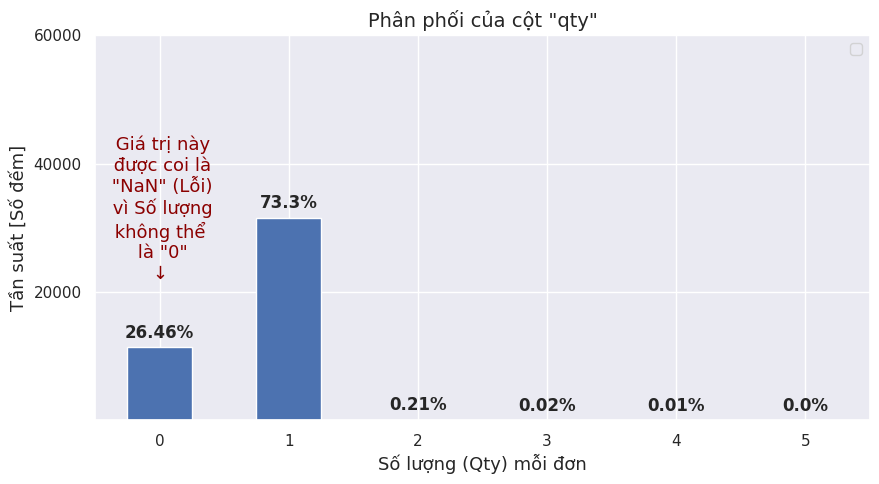

In [17]:
# ==============================================================
# VẼ BIỂU ĐỒ PHÂN PHỐI CỘT "QTY"
# ==============================================================

# Tạo figure
fig, ax = plt.subplots(figsize=(10, 5))

# Vẽ bar chart (trục Y = Count)
qty_prop.plot(kind="bar", y="Count", ax=ax)

# ️ Tiêu đề và nhãn
plt.xlabel("Số lượng (Qty) mỗi đơn", fontsize=13)
plt.ylabel("Tần suất [Số đếm]", fontsize=13)
plt.yticks(ticks=range(20000, 60001, 20000))
plt.title('Phân phối của cột "qty"', fontsize=14, fontweight=550)
plt. xticks(rotation="horizontal")
plt.legend("")  # Tắt legend

#  Thêm nhãn % lên mỗi cột
for x, y in enumerate(qty_prop["Count"]):
    qty_value = qty_prop.index[x]
    plt.text(x, y+1500, qty_prop["Proportion(%)"]. loc[qty_value],
             horizontalalignment="center", fontweight=700)

# Thêm GHI CHÚ ĐẶC BIỆT cho qty=0
plt.text(0, 22000, 
         ' Giá trị này\n được coi là\n "NaN" (Lỗi)\n vì Số lượng\n không thể \n là "0"\n↓',
         horizontalalignment="center", color="darkred", fontsize=13)

plt.show()

#### **NHẬN XÉT VỀ CỘT "QTY":**

**Quan sát từ biểu đồ:**

Phân phối cột qty cho thấy 73.3% đơn hàng có qty=1, trong khi 26.46% có qty=0 (bất thường vì đơn hàng không thể có số lượng bằng 0), và chỉ có 0.24% có qty ≥ 2.  Giá trị qty=0 có thể do data entry error, system glitch, hoặc đơn hàng bị cancelled trước khi xác nhận nhưng vẫn được ghi log vào hệ thống.

**Quyết định - Tạo Binary Feature:**

Thay vì xóa hoàn toàn cột qty (sẽ mất thông tin về việc "đơn hàng này có anomaly"), chúng ta tạo binary feature `is_qty_suspicious` với giá trị 1 nếu qty=0 (nghi ngờ) và 0 nếu qty>0 (bình thường).  Phương pháp này nhằm mục đích giữ được signal: model có thể học được rằng những đơn hàng có qty=0 thường có rejection rate khác với đơn hàng bình thường, giúp cải thiện prediction accuracy. 

In [18]:
# ==============================================================
# KIỂM TRA CORRELATION: qty=0 vs rejection
# ==============================================================

#  Justification: Kiểm tra xem qty=0 có liên quan đến rejection không
#    → Nếu có correlation mạnh → nên giữ lại thông tin này

print(" Kiểm tra mối tương quan giữa qty=0 và việc từ chối đơn hàng...")
print()

# Tính rejection rate cho qty=0
print("Rejection rate when qty=0:")
rejection_qty0 = df[df["qty"] == 0]["rejected"].value_counts(normalize=True)
print(rejection_qty0)

# Tính rejection rate cho qty>0
print("\n Rejection rate when qty>0:")
rejection_qty_positive = df[df["qty"] > 0]["rejected"].value_counts(normalize=True)
print(rejection_qty_positive)

# So sánh và kết luận
print("\n Phân tích:")
if 1 in rejection_qty0. index and 1 in rejection_qty_positive. index:
    rate_qty0 = rejection_qty0[1] * 100
    rate_qty_pos = rejection_qty_positive[1] * 100
    diff = rate_qty0 - rate_qty_pos
    
    print(f"   → Rejection rate (qty=0): {rate_qty0:.2f}%")
    print(f"   → Rejection rate (qty>0): {rate_qty_pos:.2f}%")
    print(f"   → Chênh lệch: {diff:+.2f}%")
    
    if abs(diff) > 5:
        print("\n qty=0 có correlation đáng kể với rejection")
        print("   → Nên giữ lại thông tin này bằng binary feature")
    else:
        print("\n Correlation yếu, nhưng vẫn nên giữ vì đây là anomaly data")

# ==============================================================
# TẠO BINARY FEATURE: is_qty_suspicious
# ==============================================================

print("\n" + "="*70)
print(" Tạo binary feature 'is_qty_suspicious'...")
print("="*70)

# Phương pháp: Binary Encoding
# - 1 (True) nếu qty = 0 (suspicious/anomaly)
# - 0 (False) nếu qty > 0 (normal)

#  Tạo cột mới
# (df["qty"] == 0): Tạo Boolean Series (True nếu qty=0, False nếu qty>0)
# . astype(int): Chuyển True→1, False→0
df["is_qty_suspicious"] = (df["qty"] == 0).astype(int)

print(" Đã tạo feature 'is_qty_suspicious'")

# Kiểm tra phân phối
print("\n Phân phối của 'is_qty_suspicious':")
print(df["is_qty_suspicious"].value_counts())
print("\nTỷ lệ phần trăm:")
print(df["is_qty_suspicious"].value_counts(normalize=True) * 100)

# ==============================================================
# XÓA CỘT "QTY" GỐC
# ==============================================================

# Xóa cột qty gốc (không còn cần thiết vì đã có is_qty_suspicious)
df. drop("qty", axis="columns", inplace=True)
print("\n Đã xóa cột 'qty' gốc")

# ==============================================================
# KIỂM TRA KẾT QUẢ
# ==============================================================

print("\n Thông tin DataFrame sau khi xử lý qty:")
df.info()

print("\n Các cột hiện có:")
print(df. columns.tolist())

print("\n Hoàn thành xử lý cột 'qty'!")

 Kiểm tra mối tương quan giữa qty=0 và việc từ chối đơn hàng...

Rejection rate when qty=0:
rejected
1    1.0
Name: proportion, dtype: float64

 Rejection rate when qty>0:
rejected
0    0.784668
1    0.215332
Name: proportion, dtype: float64

 Phân tích:
   → Rejection rate (qty=0): 100.00%
   → Rejection rate (qty>0): 21.53%
   → Chênh lệch: +78.47%

 qty=0 có correlation đáng kể với rejection
   → Nên giữ lại thông tin này bằng binary feature

 Tạo binary feature 'is_qty_suspicious'...
 Đã tạo feature 'is_qty_suspicious'

 Phân phối của 'is_qty_suspicious':
is_qty_suspicious
0    31621
1    11379
Name: count, dtype: int64

Tỷ lệ phần trăm:
is_qty_suspicious
0    73.537209
1    26.462791
Name: proportion, dtype: float64

 Đã xóa cột 'qty' gốc

 Thông tin DataFrame sau khi xử lý qty:
<class 'pandas.core.frame.DataFrame'>
Index: 43000 entries, 0 to 128969
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0  

<a id="amount"></a>
### <br>**4.b.vii. Phân tích cột "amount" (Số tiền).**

**Mục đích:** 
- Kiểm tra phân phối của số tiền đơn hàng
- Xác định và xử lý outliers (giá trị ngoại lệ)

**Phương pháp: Log Transformation**

Sử dụng Log Transformation để chuẩn hóa phân phối thay vì loại bỏ outliers. Phương pháp này cho phép giữ nguyên 100% dữ liệu trong khi vẫn giảm skewness.  Các giá trị amount cao (5000 Rs) là đơn hàng đắt tiền hợp lệ (saree sets, premium products), không phải noise hay errors, nên cần preserve để model có thể học được patterns ở mọi price ranges.

In [19]:
# ==============================================================
# KIỂM TRA GIÁ TRỊ amount = 0
# ==============================================================

#  Đếm số dòng có amount = 0
amount0_count = (df["amount"] == 0).sum()

print(f"🔍 Kiểm tra giá trị amount = 0...")
print(f"   → Tìm thấy {amount0_count} dòng có amount = 0")
print(f"   → Tỷ lệ: {amount0_count/len(df)*100:.2f}%")

# Giải thích: Đơn hàng không thể có amount = 0
# → Đây là missing data hoặc lỗi nhập liệu (data entry error)

🔍 Kiểm tra giá trị amount = 0...
   → Tìm thấy 769 dòng có amount = 0
   → Tỷ lệ: 1.79%


In [20]:
# ==============================================================
# XỬ LÝ amount = 0 - XÓA DÒNG (Không tạo NaN)
# ==============================================================

print("\n Xử lý các dòng có amount = 0...")

# Đếm trước khi xóa
before_drop = len(df)

# Xóa các dòng có amount = 0
df = df[df["amount"] != 0]

# Đếm sau khi xóa
after_drop = len(df)
dropped = before_drop - after_drop

print(f"   → Đã xóa {dropped} dòng có amount = 0")
print(f"   → Còn lại: {after_drop} dòng")

# Kiểm tra: Không còn NaN
print(f" Không có giá trị NaN (NaN count: {df['amount'].isna().sum()})")


 Xử lý các dòng có amount = 0...
   → Đã xóa 769 dòng có amount = 0
   → Còn lại: 42231 dòng
 Không có giá trị NaN (NaN count: 6966)


<br>**Kiểm tra Phân phối của cột "amount"**


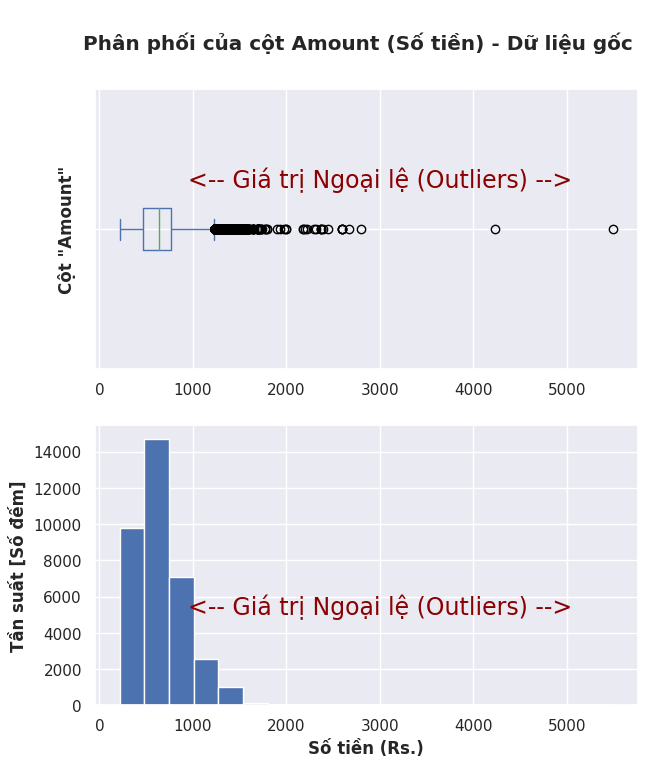

In [21]:
# ==============================================================
# VẼ BIỂU ĐỒ PHÂN PHỐI "AMOUNT" (Trước khi áp dụng Log)
# ==============================================================

#  Tạo 2 biểu đồ: Boxplot + Histogram
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 8))

#  Tiêu đề chung
plt.suptitle("\nPhân phối của cột Amount (Số tiền) - Dữ liệu gốc", fontweight=600)

#  Biểu đồ 1: BOXPLOT (Biểu đồ hộp)
df["amount"].plot(kind="box", vert=False, ax=ax1)
ax1.text(3000, 1.15, "<-- Giá trị Ngoại lệ (Outliers) -->", 
         fontsize=17, horizontalalignment="center", color="darkred")
ax1.set_ylabel('Cột "Amount"', fontsize=12, fontweight=600)
ax1.set_yticklabels(labels="")

#  Biểu đồ 2: HISTOGRAM (Biểu đồ tần suất)
df["amount"].plot(kind="hist", bins=20, ax=ax2)
ax2.text(3000, 5000, "<-- Giá trị Ngoại lệ (Outliers) -->", 
         fontsize=17, horizontalalignment="center", color="darkred")
ax2.set_ylabel('Tần suất [Số đếm]', fontsize=12, fontweight=600)
ax2.set_xlabel("Số tiền (Rs.)", fontsize=12, fontweight=600)

plt.show()

#### NHẬN XÉT:

**Quan sát từ biểu đồ:**

Phân phối amount rất lệch phải (right-skewed) với nhiều outliers ở giá trị cao (>2000 Rs).  Phần lớn đơn hàng tập trung ở khoảng 200-800 Rs, trong khi có một số đơn hàng đắt tiền (expensive orders) lên đến 5000-10000 Rs.

**Quyết định - Áp dụng Log Transformation:**

Chúng ta sử dụng Log Transformation (`log(amount + 1)`) thay vì loại bỏ outliers vì các lý do sau:

**Lý do 1 - Preserve Information:** Các giá trị amount cao (5000 Rs) là đơn hàng đắt tiền hợp lệ (saree sets, premium products), không phải errors.   Nếu loại bỏ chúng, model sẽ mất thông tin quan trọng về việc "high-value orders có rejection rate khác thế nào so với low-value orders".

**Lý do 2 - Normalize Distribution:** Log transformation giảm skewness, làm cho distribution gần với Normal distribution hơn, giúp model học tốt hơn (đặc biệt với các thuật toán giả định Normal distribution như Logistic Regression

<br>**Kiểm tra phân phối mới của "amount" (sau khi bỏ outliers)** 


In [22]:
# ==============================================================
# XỬ LÝ VÀ LOG TRANSFORM CỘT "AMOUNT" - AN TOÀN NHẤT
# ==============================================================

print(" Xử lý và transform cột 'amount'...")

# BƯỚC 1: Chuyển sang numeric
print("\n Chuyển đổi dtype...")
df['amount'] = pd. to_numeric(df['amount'], errors='coerce')
print(f"    Dtype: {df['amount'].dtype}")

# BƯỚC 2: Xóa NaN
print("\n Xử lý NaN...")
nan_before = df['amount'].isna(). sum()
df = df.dropna(subset=['amount'])
nan_after = df['amount'].isna().sum()
print(f"   → Đã xóa {nan_before - nan_after} NaN values")

# BƯỚC 3: Xóa giá trị <= 0
print("\n Xử lý giá trị không hợp lệ...")
zero_negative = (df['amount'] <= 0). sum()
if zero_negative > 0:
    print(f"   → Tìm thấy {zero_negative} giá trị <= 0")
    df = df[df['amount'] > 0]
    print(f"    Đã xóa.  Còn lại: {len(df)} dòng")

# BƯỚC 4: Thống kê trước transform
print("\n Thống kê TRƯỚC transform:")
print(df['amount'].describe())

# BƯỚC 5: Log transformation
print("\n Áp dụng Log Transformation...")
df['amount_log'] = np.log1p(df['amount'])
print("    Đã tạo 'amount_log'")

# BƯỚC 6: Thống kê sau transform
print("\n Thống kê SAU transform:")
print(df['amount_log'].describe())

# BƯỚC 7: Reset index
df = df.reset_index(drop=True)

print("\n HOÀN THÀNH!")
print(f"📋 Dataset cuối: {len(df)} dòng, {len(df.columns)} cột")

 Xử lý và transform cột 'amount'...

 Chuyển đổi dtype...
    Dtype: float64

 Xử lý NaN...
   → Đã xóa 6966 NaN values

 Xử lý giá trị không hợp lệ...

 Thống kê TRƯỚC transform:
count    35265.000000
mean       665.135552
std        265.671570
min        218.100000
25%        463.810000
50%        635.000000
75%        771.000000
max       5495.000000
Name: amount, dtype: float64

 Áp dụng Log Transformation...
    Đã tạo 'amount_log'

 Thống kê SAU transform:
count    35265.000000
mean         6.427036
std          0.385448
min          5.389528
25%          6.141629
50%          6.455199
75%          6.648985
max          8.611776
Name: amount_log, dtype: float64

 HOÀN THÀNH!
📋 Dataset cuối: 35265 dòng, 11 cột


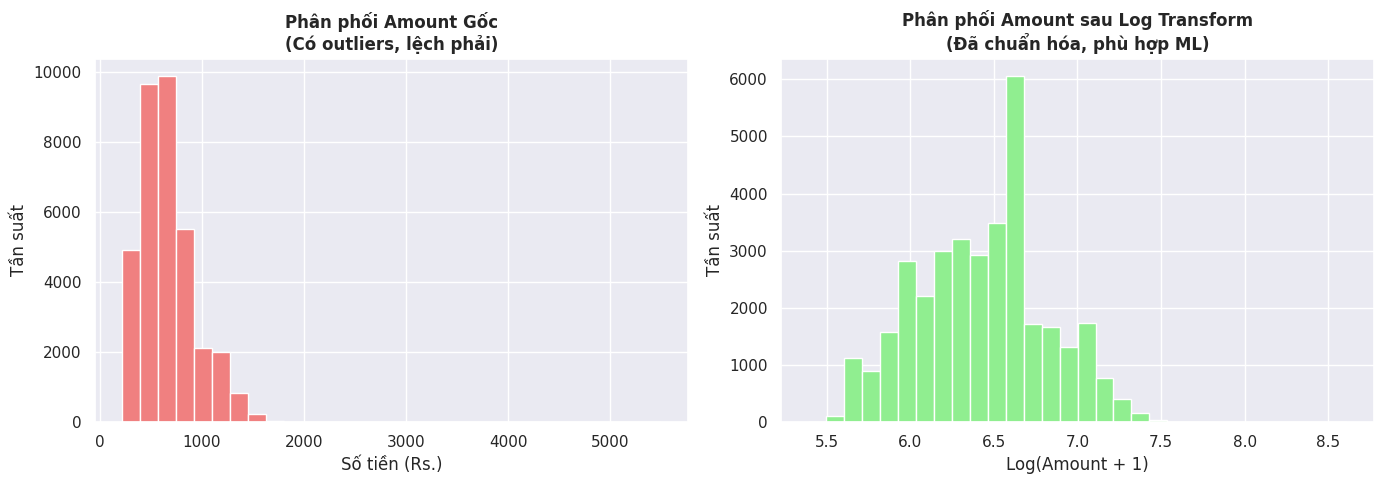


 So sánh độ lệch (Skewness):
   Dữ liệu gốc: 1.26 (rất lệch)
   Sau Log transform: 0.06 (ít lệch hơn)

 Hoàn thành xử lý cột 'amount'!
Dataset hiện có: 35265 dòng, 11 cột


In [23]:
# ==============================================================
# VẼ BIỂU ĐỒ SO SÁNH: Original vs Log Transformed
# ==============================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Biểu đồ 1: Dữ liệu gốc (có outliers, skewed)
df["amount"].dropna().plot(kind="hist", bins=30, ax=ax1, color="lightcoral")
ax1.set_title("Phân phối Amount Gốc\n(Có outliers, lệch phải)", 
              fontsize=12, fontweight=600)
ax1.set_xlabel("Số tiền (Rs.)")
ax1.set_ylabel("Tần suất")

#  Biểu đồ 2: Sau Log transformation (normalized)
df["amount_log"].dropna().plot(kind="hist", bins=30, ax=ax2, color="lightgreen")
ax2.set_title("Phân phối Amount sau Log Transform\n(Đã chuẩn hóa, phù hợp ML)", 
              fontsize=12, fontweight=600)
ax2.set_xlabel("Log(Amount + 1)")
ax2.set_ylabel("Tần suất")

plt.tight_layout()
plt.show()

# So sánh độ lệch (skewness)
print("\n So sánh độ lệch (Skewness):")
print(f"   Dữ liệu gốc: {df['amount'].skew():.2f} (rất lệch)")
print(f"   Sau Log transform: {df['amount_log']. skew():.2f} (ít lệch hơn)")

# Reset index (vì đã xóa một số dòng)
df = df.reset_index(drop=True)

print("\n Hoàn thành xử lý cột 'amount'!")
print(f"Dataset hiện có: {len(df)} dòng, {len(df.columns)} cột")

### **4.b.viii.  Phân tích cột "fulfilment" (Nguồn thực hiện đơn hàng)**

**Mục đích:** Kiểm tra phân phối của 2 loại fulfilment: Amazon (FBA) vs Merchant (FBM)

**Phương pháp:** Value counts + proportion analysis

In [24]:
# tạo dataframe để kiểm tra tỷ lệ % của 2 loại "fulfilment" (Merchant vs Amazon)
df_cat = df["fulfilment"].value_counts().to_frame()
# Thêm cột tỷ lệ %
df_cat["proportion"] = round(df["fulfilment"].value_counts(normalize = True)*100,2)
# Thêm dấu "%" vào
df_cat["proportion"] = df_cat["proportion"].astype(str).str.cat(np.full((2,),"%"))
# Đổi tên các cột cho đẹp
df_cat = (df_cat.reset_index()
          .rename(columns = {"fulfilment":"count","index":"fulfilment_type"}))
# In bảng ra
df_cat

,count,count,proportion
0,Merchant,30351,86.07%
1,Amazon,4914,13.93%


#### NHẬN XÉT:

**Quan sát:** Phân phối lệch (Merchant ~86%, Amazon ~13%) nhưng cả 2 nhóm đều có số lượng đủ lớn (không quá nhỏ) nên vẫn tốt cho model học.

**Quyết định:** Giữ nguyên, không xử lý gì thêm. 

### **4.b.ix. Phân tích cột "saleschannel" (Kênh bán hàng)**

**Mục đích:** Kiểm tra có bao nhiêu sales channels

In [25]:
# ==============================================================
# PHÂN TÍCH CỘT "SALESCHANNEL"
# ==============================================================

# Tạo dataframe để kiểm tra tỷ lệ %
df_cat = df["saleschannel"]. value_counts().to_frame()

# Thêm cột tỷ lệ %
df_cat["proportion"] = round(df["saleschannel"].value_counts(normalize=True) * 100, 4)

num_values = len(df_cat)  # Số lượng unique values thực tế

# Thêm dấu "%" vào (dùng số lượng thực tế)
df_cat["proportion"] = df_cat["proportion"].astype(str).str. cat(np.full((num_values,), "%"))

# Đổi tên các cột cho đẹp
df_cat = df_cat.reset_index().rename(columns={"saleschannel": "count", "index": "saleschannel_type"})

# In bảng ra
print(" Phân phối Saleschannel:")
print(df_cat)

 Phân phối Saleschannel:
       count  count proportion
0  Amazon.in  35265     100.0%


#### ** NHẬN XÉT:**

**Quan sát:** 

Sau quá trình làm sạch dữ liệu (xóa amount=0, qty=0, status không rõ ràng), cột "saleschannel" chỉ còn lại **100% là "Amazon.  in"** (35,265 dòng).    Dòng duy nhất "Non-Amazon" trong raw data đã bị loại bỏ trong các bước tiền xử lý trước đó.

**Phân tích:**

Cột này không còn cung cấp thông tin hữu ích (zero variance - không có sự khác biệt giữa các dòng).   Trong machine learning, features với zero variance không giúp model phân biệt được giữa các classes vì tất cả samples đều có cùng một giá trị.
-->Xóa cột

In [26]:
# Xóa (drop) cột "saleschannel"
df.drop("saleschannel", axis = "columns", inplace = True)

### **4.b.x. Phân tích cột "shipservicelevel" (Mức độ dịch vụ vận chuyển)**

**Mục đích:** Kiểm tra phân phối Standard vs Expedited shipping

In [27]:
# tạo dataframe để kiểm tra tỷ lệ % (Standard vs Expedited)
df_cat = df["shipservicelevel"].value_counts().to_frame()
# Thêm cột tỷ lệ %
df_cat["proportion"] = round(df["shipservicelevel"].value_counts(normalize = True)*100,2)
# Thêm dấu "%" vào
df_cat["proportion"] = df_cat["proportion"].astype(str).str.cat(np.full((2,),"%"))
# Đổi tên các cột cho đẹp
df_cat = (df_cat.reset_index()
          .rename(columns = {"shipservicelevel":"count","index":"shipservicelevel_type"}))
# In bảng ra
df_cat

,count,count,proportion
0,Standard,30355,86.08%
1,Expedited,4910,13.92%


#### NHẬN XÉT:

**Quan sát:** Lệch (Standard nhiều hơn) nhưng cả 2 nhóm đều có số lượng đủ lớn. 

**Quyết định:** Giữ nguyên

### **4.b. xi. Phân tích cột "category" (Loại sản phẩm)**

**Mục đích:** Kiểm tra phân phối các loại sản phẩm (kurta, set, saree, etc.)

**Phương pháp:** Bar chart visualization

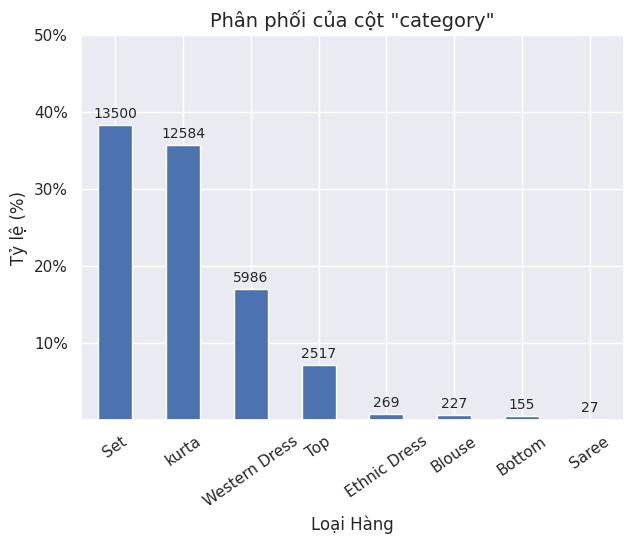

In [28]:
# ----- BẮT ĐẦU VẼ BIỂU ĐỒ -----
fig,ax = plt.subplots(figsize = (7,5))

# tạo dataframe để kiểm tra tỷ lệ % của các loại 'category'
df_cat = df["category"].value_counts().to_frame()
# Thêm cột tỷ lệ %
df_cat["proportion"] = round(df["category"].value_counts(normalize = True)*100,2)
# Thêm cột nhãn % (để lát vẽ lên biểu đồ)
df_cat["proportion_label"] = df_cat["proportion"].astype(str).str.cat(np.full((len(df_cat),),"%"))

# Đổi tên cột 'index' (tên cũ) thành 'category_type'
# (Tớ đã sửa lại code ở đây cho chuẩn)
df_cat = df_cat.reset_index().rename(columns = {"category":"category_type", "count":"count"})

# Vẽ biểu đồ cột (bar), X là 'category_type', Y là 'proportion'
df_cat.plot(
    kind = "bar", x = "category_type",y = "proportion",
    legend = "", ax = ax
)
# Đặt Tiêu đề và Nhãn 
plt.xlabel("Loại Hàng")
plt.ylabel("Tỷ lệ (%)")
plt.title('Phân phối của cột "category"', fontsize = 14)
plt.xticks(rotation = 35) # Xoay chữ trục X 35 độ
plt.yticks(ticks = range(10,51,10) ,labels =["10%","20%","30%","40%","50%"])

# Thêm nhãn số đếm (Count) lên trên mỗi cột
for x,y in enumerate(df_cat["count"]):
    plt.text(x,1+df_cat["proportion"][x],y,
             fontsize = 10, horizontalalignment = "center")
plt.show()

#### NHẬN XÉT:

**Quan sát:** Phân phối lệch (Set, Kurta, Western Dress là chính) nhưng tất cả categories đều có số lượng đủ để model học.

**Quyết định:** Giữ nguyên

### **4.b.xii. Phân tích cột "b2b" (Business-to-Business)**

**Mục đích:** Kiểm tra tỷ lệ đơn hàng B2B (bán cho doanh nghiệp) vs B2C (bán cho cá nhân)

In [29]:
# tạo dataframe để kiểm tra tỷ lệ % (True vs False)
df_cat = df["b2b"].value_counts().to_frame()
# Thêm cột tỷ lệ %
df_cat["proportion"] = round(df["b2b"].value_counts(normalize = True)*100,2)
# Thêm dấu "%" vào
df_cat["proportion"] = df_cat["proportion"].astype(str).str.cat(np.full((2,),"%"))
# Đổi tên các cột cho đẹp
df_cat = (df_cat.reset_index()
          .rename(columns = {"b2b":"count","index":"b2b_type"}))
# In bảng ra
df_cat

,count,count,proportion
0,False,35036,99.35%
1,True,229,0.65%


#### **NHẬN XÉT:**

**Quan sát:** 99.35% là B2C (False), chỉ có 303 đơn B2B (True - 0.65%).  Tuy lệch nhưng nhóm thiểu số vẫn có 303 samples (không quá nhỏ). 

**Quyết định:** 
-  Giữ lại feature này
-  Chuyển dtype từ `bool` → `object` để model hiểu đây là categorical (2 loại), không phải số 0/1

In [30]:
# đổi kiểu dữ liệu 'b2b' (hiện đang là bool True/False) sang 'object' (chuỗi)
# Model sẽ hiểu đây là 2 "loại" (True/False) chứ không phải số (1/0)
df["b2b"] = df["b2b"].astype(object)

### **4.b.xiii. Phân tích cột "shipstate" (Bang giao hàng)**

**Mục đích:** 
- Kiểm tra phân phối 37 bang của Ấn Độ
- Tạo feature mới "region" (vùng địa lý) để giảm cardinality

**Phương pháp: Feature Engineering - Grouping**

Ấn Độ có 28 states + 8 union territories + 1 capital = 37 administrative divisions, nhưng có thể gom thành 6 vùng địa lý chính: North India, South India, East India, West India, Central India, và Northeast India.  


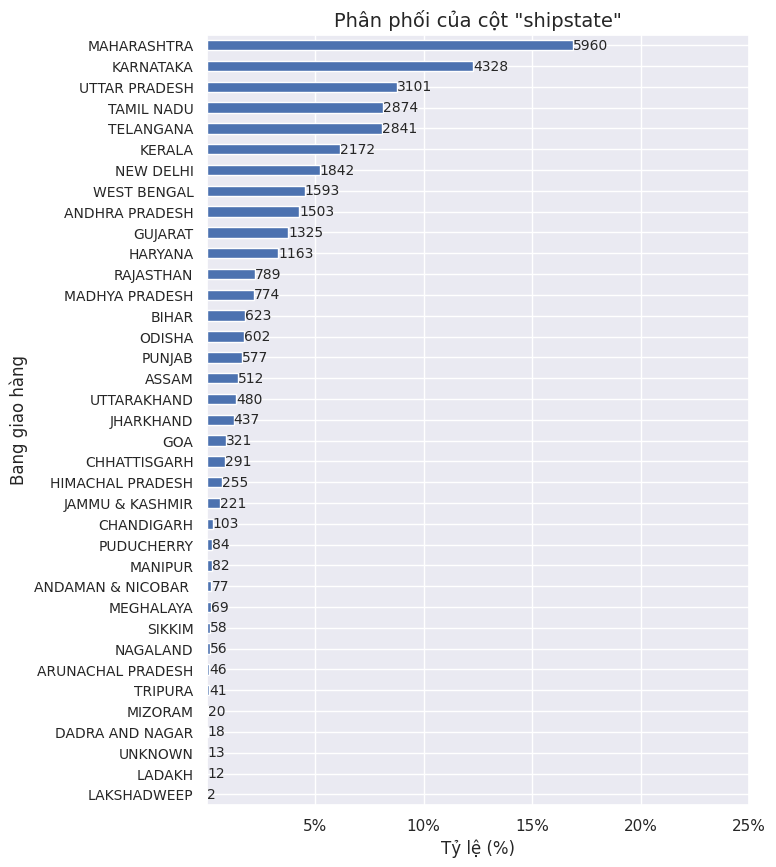

In [31]:
# tạo dataframe để kiểm tra tỷ lệ % của các 'shipstate'
df_cat = df["shipstate"].value_counts().to_frame()
# Thêm cột tỷ lệ %
df_cat["proportion"] = round(df["shipstate"].value_counts(normalize = True)*100,2)
# Thêm cột nhãn % (dạng chuỗi)
df_cat["proportion_str"] = df_cat["proportion"].astype(str).str.cat(np.full((len(df_cat),),"%"))

# Đổi tên cột 'index' (tên cũ) thành 'shipstate_type'
# (Tớ đã sửa lại code ở đây cho chuẩn)
df_cat = (df_cat.reset_index()
          .rename(columns = {"shipstate":"shipstate_type", "count":"count"}))

# ----- BẮT ĐẦU VẼ BIỂU ĐỒ -----
# Sắp xếp các bang (từ ít -> nhiều) để vẽ biểu đồ ngang (barh) cho đẹp
df_cat = df_cat.sort_values(by = "proportion").reset_index(drop = True)
fig,ax = plt.subplots(figsize = (7,10)) # Biểu đồ cao 10 inch

# Vẽ biểu đồ ngang (barh), Y là 'shipstate_type', X là 'proportion'
df_cat.plot(
    kind = "barh", x = "shipstate_type",y = "proportion",
    legend = "", ax = ax
)
# Đặt Tiêu đề và Nhãn (ĐÃ DỊCH)
plt.ylabel("Bang giao hàng")
plt.xlabel("Tỷ lệ (%)")
plt.title('Phân phối của cột "shipstate"', fontsize = 14)
# Hiển thị tất cả 37 tên bang trên trục Y
plt.yticks(ticks = list(range(0,len(df_cat))) ,labels=df_cat["shipstate_type"],
          fontsize = 10)
plt.xticks(ticks = range(5,26,5) ,labels =["5%","10%","15%","20%","25%"])

# Thêm nhãn số đếm (Count) vào cuối mỗi thanh ngang
for x,y in enumerate(df_cat["count"]):
    plt.text((df_cat["proportion"][x]),x,y,
             fontsize = 10, verticalalignment = "center")
plt.show()

#### **📊 NHẬN XÉT A: Phân phối ban đầu (37 states)**

**Quan sát:** 

Phân phối rất lệch với Maharashtra và Karnataka chiếm phần lớn.  Một số bang Đông-Bắc (Northeast states) và Union Territories có số lượng rất nhỏ (dưới 100 orders), khiến model khó học patterns cho những bang này.  Ngoài ra, có 13 dòng "UNKNOWN" (không xác định được bang). 

**Quyết định:**
1. Xóa 13 dòng "UNKNOWN" (chiếm tỷ lệ nhỏ)
2. Tạo feature mới "region" - gom 37 bang thành 6 vùng địa lý
3. Xóa cột "shipstate" gốc sau khi có "region"

In [32]:
# ==============================================================
# TẠO FEATURE MỚI: "REGION" (Vùng địa lý)
# ==============================================================
# Feature Engineering: Gom 37 bang → 6 vùng
# - Giảm cardinality: 37 → 6
# - Giữ được thông tin địa lý
# - Model dễ học hơn (6 categories thay vì 37)

print("Tạo feature: Region")

df["region"] = df["shipstate"]. replace({
    # WEST INDIA (Tây Ấn)
    "MAHARASHTRA": "westindia", "GUJARAT": "westindia",
    "RAJASTHAN": "westindia", "GOA": "westindia",
    "DADRA AND NAGAR": "westindia",
    
    # SOUTH INDIA (Nam Ấn)
    "KARNATAKA": "southindia", "TAMIL NADU": "southindia",
    "KERALA": "southindia", "ANDHRA PRADESH": "southindia",
    "TELANGANA": "southindia", "PUDUCHERRY": "southindia",
    "LAKSHADWEEP": "southindia",
    
    # NORTH INDIA (Bắc Ấn)
    "UTTAR PRADESH": "northindia", "HARYANA": "northindia",
    "PUNJAB": "northindia", "UTTARAKHAND": "northindia",
    "HIMACHAL PRADESH": "northindia", "JAMMU & KASHMIR": "northindia",
    "CHANDIGARH": "northindia", "LADAKH": "northindia",
    
    # EAST INDIA (Đông Ấn)
    "WEST BENGAL": "eastindia", "JHARKHAND": "eastindia",
    "ODISHA": "eastindia", "BIHAR": "eastindia",
    "CHHATTISGARH": "eastindia", "ANDAMAN & NICOBAR ": "eastindia",
    
    # CENTRAL INDIA (Trung Ấn)
    "MADHYA PRADESH": "centralindia", "NEW DELHI": "centralindia",
    
    # NORTHEAST INDIA (Đông Bắc Ấn)
    "ASSAM": "northeastindia", "MEGHALAYA": "northeastindia",
    "TRIPURA": "northeastindia", "SIKKIM": "northeastindia",
    "MANIPUR": "northeastindia", "MIZORAM": "northeastindia",
    "NAGALAND": "northeastindia", "ARUNACHAL PRADESH": "northeastindia"
})

# Xóa các dòng "UNKNOWN"
before_drop = len(df)
df = df[df["shipstate"] != "UNKNOWN"]
after_drop = len(df)

Tạo feature: Region


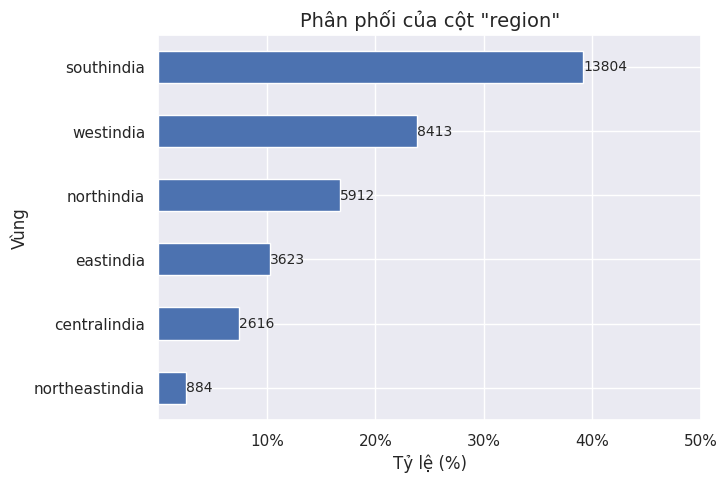

In [33]:
# ==============================================================
# VẼ BIỂU ĐỒ: Phân phối "REGION" (6 vùng)
# ==============================================================

df_cat = df["region"].value_counts().to_frame()
df_cat["proportion"] = round(df["region"].value_counts(normalize=True)*100, 2)
df_cat["proportion_str"] = df_cat["proportion"]. astype(str).str.cat(np.full((len(df_cat),), "%"))
df_cat = df_cat.reset_index(). rename(columns={"region":"region_name", "count":"count"})
df_cat = df_cat. sort_values(by="proportion"). reset_index(drop=True)

fig, ax = plt.subplots(figsize=(7, 5))
df_cat.plot(kind="barh", x="region_name", y="proportion", legend="", ax=ax)

plt.ylabel("Vùng")
plt.xlabel("Tỷ lệ (%)")
plt.title('Phân phối của cột "region"', fontsize=14)
plt. yticks(ticks=list(range(0, len(df_cat))), labels=df_cat["region_name"])
plt. xticks(ticks=range(10, 51, 10), labels=["10%", "20%", "30%", "40%", "50%"])

for x, y in enumerate(df_cat["count"]):
    plt.text((df_cat["proportion"][x]), x, y, fontsize=10, verticalalignment="center")

plt.show()

#### **NHẬN XÉT B: Sau khi tạo "region"**

**Quan sát:** 

Phân phối 6 vùng vẫn lệch (South India và West India chiếm phần lớn) nhưng TẤT CẢ các vùng đều có số lượng đủ lớn (ngay cả Northeast India có số lượng thấp nhất cũng vẫn có vài trăm orders). Điều này tốt hơn nhiều so với việc có 37 categories với một số bang chỉ có vài chục orders.

**Kết quả:**
-  Giảm cardinality: 37 states → 6 regions
-  Tất cả regions đều có sample size đủ lớn để model học
-  Vẫn giữ được thông tin địa lý quan trọng

**Quyết định cuối:** 
- Giữ "region" 
- Xóa "shipstate" (redundant)

In [34]:
# Xóa (drop) cột "shipstate" gốc (vì đã có cột "region" thay thế)
df.drop("shipstate",axis = "columns", inplace = True)

# reset (đặt lại) chỉ mục (index) của dataframe sau khi đã xóa nhiều dòng
df = df.reset_index(drop = True)
# Kiểm tra lại thông tin lần cuối, xem còn bao nhiêu cột
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35252 entries, 0 to 35251
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fulfilment         35252 non-null  object 
 1   shipservicelevel   35252 non-null  object 
 2   category           35252 non-null  object 
 3   size               35252 non-null  object 
 4   amount             35252 non-null  float64
 5   b2b                35252 non-null  object 
 6   rejected           35252 non-null  int64  
 7   is_qty_suspicious  35252 non-null  int64  
 8   amount_log         35252 non-null  float64
 9   region             35252 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 2.7+ MB


<a id="final_wrangle"></a>
## **4.c. FINAL WRANGLE FUNCTION
**Mục đích:** 
Tổng hợp TẤT CẢ các bước làm sạch đã phân tích ở EDA vào một hàm duy nhất `final_wrangle(filepath)` để có thể tái sử dụng. 

**Phương pháp: ETL Pipeline**
- **Extract:** Đọc file CSV
- **Transform:** Áp dụng tất cả cleaning rules
- **Load:** Return DataFrame sạch, sẵn sàng cho modeling

In [35]:
# ==============================================================
# HÀM FINAL_WRANGLE (Xử lý và Làm sạch Dữ liệu Tổng hợp)
# ==============================================================

def final_wrangle(filepath):
    # BƯỚC 1: Đọc file
    print(" Đang tiến hành đọc dữ liệu từ tập tin...")
    df = pd.read_csv(filepath, low_memory=False)
    print(f"   → Đã tải thành công {len(df)} dòng và {len(df.columns)} cột.")
    
    # BƯỚC 2: Chuẩn hóa tên cột (Clean column names)
    col = [element.lower().replace(" ", "").replace("-", "") for element in df.columns]
    df.columns = col
    
    # BƯỚC 3: Loại bỏ các thuộc tính dư thừa (Drop redundant columns)
    df.drop(["index", "date", "fulfilledby", "currency", "unnamed:22",
             "promotionids", "courierstatus", "shipcountry"],
            axis="columns", inplace=True)
    
    # BƯỚC 4: Xử lý giá trị thiếu cho thông tin địa lý (Fill NaN for location)
    df["shipstate"].fillna("unknown", inplace=True)
    df["shipcity"].fillna("unknown", inplace=True)
    df["shippostalcode"].fillna(0, inplace=True)
    df["shippostalcode"] = df["shippostalcode"].astype(int).astype(object)
    
    # BƯỚC 5: Chuẩn hóa tên bang (Standardize shipstate)
    df["shipstate"] = df["shipstate"].str.upper()
    df["shipstate"].replace({
        "PONDICHERRY": "PUDUCHERRY", "RAJSHTHAN": "RAJASTHAN", "RAJSTHAN": "RAJASTHAN",
        "RJ": "RAJASTHAN", "PB": "PUNJAB", "PUNJAB/MOHALI/ZIRAKPUR": "PUNJAB",
        "ORISSA": "ODISHA", "DELHI": "NEW DELHI", "NL": "UNKNOWN", "APO": "UNKNOWN", "AR": "UNKNOWN"
    }, inplace=True)
    
    # BƯỚC 6: Loại bỏ các bản ghi trùng lặp (Drop duplicates)
    df.drop_duplicates(inplace=True)
    
    # BƯỚC 7-9: Thu hẹp phạm vi nghiên cứu: Chỉ giữ đơn hàng đơn lẻ (Remove multi-product orders)
    df = df[df["orderid"].duplicated(keep=False) == False]
    df.drop("orderid", axis=1, inplace=True)
    
    # BƯỚC 10: Thiết lập biến mục tiêu "rejected" (Create target variable)
    known_value = ["Cancelled", 'Shipped - Returned to Seller', 'Shipped - Rejected by Buyer',
                   'Shipped - Returning to Seller', 'Shipped - Delivered to Buyer']
    df = df[df["status"].isin(known_value)]
    
    rejected = ["Cancelled", 'Shipped - Returned to Seller', 'Shipped - Rejected by Buyer',
                'Shipped - Returning to Seller']
    df["rejected"] = df["status"].isin(rejected).astype(int)
    df.drop("status", axis="columns", inplace=True)
    
    # BƯỚC 11: Loại bỏ đặc trưng có số chiều cao (Drop high cardinality features)
    df.drop(["style", "sku", "shipcity", "shippostalcode", "asin"], axis=1, inplace=True)
    
    # BƯỚC 12: XỬ LÝ SỐ LƯỢNG (QTY) → Trích xuất đặc trưng nhị phân
    print("\n Đang xử lý thuộc tính 'qty' (Số lượng)...")
    df["is_qty_suspicious"] = (df["qty"] == 0).astype(int)
    df.drop("qty", axis="columns", inplace=True)
    print("   → Đã tạo đặc trưng mới: 'is_qty_suspicious'.")
    
    # BƯỚC 13: XỬ LÝ GIÁ TRỊ ĐƠN HÀNG (AMOUNT) → Biến đổi Logarit
    print("\n Đang xử lý thuộc tính 'amount' (Giá trị đơn hàng)...")
    
    # 13.1.  CHUYỂN ĐỔI DTYPE SANG NUMERIC (QUAN TRỌNG!)
    print("   → Chuyển đổi dtype sang numeric...")
    df["amount"] = pd.to_numeric(df["amount"], errors='coerce')
    print(f"   → Dtype hiện tại: {df['amount'].dtype}")
    
    # 13.2.  Kiểm tra và xử lý NaN
    nan_count = df["amount"].isna().sum()
    if nan_count > 0:
        print(f"   → Tìm thấy {nan_count} giá trị NaN, đang xóa...")
        df = df.dropna(subset=["amount"])
        print(f"   → Đã xóa {nan_count} dòng có NaN")
    
    # 13.3. Xóa các dòng có amount = 0
    amount_zero_count = (df["amount"] == 0). sum()
    if amount_zero_count > 0:
        print(f"   → Tìm thấy {amount_zero_count} dòng có amount=0")
        df = df[df["amount"] != 0]
        print(f"   → Đã xóa {amount_zero_count} dòng")
    
    # 13. 4. Xóa các giá trị âm (nếu có)
    negative_count = (df["amount"] < 0).sum()
    if negative_count > 0:
        print(f"   → Tìm thấy {negative_count} giá trị âm, đang xóa...")
        df = df[df["amount"] > 0]
    
    # 13.5.  ÁP DỤNG LOG TRANSFORMATION (Bây giờ sẽ hoạt động!)
    print("   → Áp dụng Log Transformation...")
    df["amount_log"] = np.log1p(df["amount"])
    print("   Đã tạo feature 'amount_log'")
    
    print(f"   → Số dòng còn lại: {len(df)}")
    
    # BƯỚC 14: Loại bỏ "saleschannel"
    df.drop("saleschannel", axis="columns", inplace=True)
    
    # BƯỚC 15: Tạo đặc trưng vùng miền "region" (Feature Engineering)
    print("\n Đang thực hiện trích xuất đặc trưng 'region' (Vùng miền)...")
    df["region"] = df["shipstate"].replace({
        "MAHARASHTRA": "westindia", "KARNATAKA": "southindia",
        "PUDUCHERRY": "southindia", "TELANGANA": "southindia",
        "ANDHRA PRADESH": "southindia", "HARYANA": "northindia",
        "JHARKHAND": "eastindia", "CHHATTISGARH": "eastindia",
        "ASSAM": "northeastindia", "ODISHA": "eastindia",
        "UTTAR PRADESH": "northindia", "GUJARAT": "westindia",
        "TAMIL NADU": "southindia", "UTTARAKHAND": "northindia",
        "WEST BENGAL": "eastindia", "RAJASTHAN": "westindia",
        "NEW DELHI": "centralindia", "MADHYA PRADESH": "centralindia",
        "KERALA": "southindia", "JAMMU & KASHMIR": "northindia",
        "BIHAR": "eastindia", "MEGHALAYA": "northeastindia",
        "PUNJAB": "northindia", "GOA": "southindia",
        "TRIPURA": "northeastindia", "CHANDIGARH": "northindia",
        "HIMACHAL PRADESH": "northindia", "SIKKIM": "northeastindia",
        "ANDAMAN & NICOBAR ": "eastindia", "MANIPUR": "northeastindia",
        "MIZORAM": "northeastindia", "NAGALAND": "northeastindia",
        "ARUNACHAL PRADESH": "northeastindia", "LADAKH": "northindia",
        "DADRA AND NAGAR": "westindia", "LAKSHADWEEP": "southindia"
    })
    
    # Loại bỏ các bang không xác định
    df = df[df["shipstate"] != "UNKNOWN"]
    df.drop("shipstate", axis="columns", inplace=True)
    print("   → Đã tạo đặc trưng 'region' (gồm 6 vùng địa lý).")
    
    # BƯỚC 16: Chuyển đổi kiểu dữ liệu b2b
    df["b2b"] = df["b2b"].astype(object)
    
    # BƯỚC 17: Đặt lại chỉ mục
    df = df.reset_index(drop=True)
    
    # BƯỚC 18: KIỂM TRA CHẤT LƯỢNG DỮ LIỆU CUỐI CÙNG (FINAL DATA QUALITY CHECK)
    print("\n Kiểm tra chất lượng dữ liệu lần cuối...")
    nan_count = df.isna().sum()
    total_nans = nan_count.sum()
    
    if total_nans > 0:
        print("   CẢNH BÁO: Phát hiện giá trị thiếu (NaN) trong dữ liệu:")
        print(nan_count[nan_count > 0])
        raise ValueError("   LỖI: DataFrame chứa giá trị NaN! Quá trình SMOTE sẽ thất bại!")
    else:
        print("   Không phát hiện giá trị thiếu. Dữ liệu sẵn sàng cho SMOTE!")
    
    print(f"\n Bộ dữ liệu hoàn chỉnh: {len(df)} dòng, {len(df.columns)} cột.")
    print(f"   Danh sách cột: {df.columns.tolist()}")
    
    return df

## **5. DATA LOADING (Tải dữ liệu đã làm sạch)**

**Mục đích:** Áp dụng hàm `final_wrangle()` để có được dataset cuối cùng, sạch, sẵn sàng cho modeling

**Phương pháp: ETL Pipeline Execution**
- Execute toàn bộ cleaning pipeline một lần duy nhất
- Verify kết quả (shape, columns, no NaN)

In [36]:
# 5. TẢI DỮ LIỆU - THỰC THI HÀM FINAL_WRANGLE()
filepath_list = glob("/kaggle/input/unlock-profits-with-e-commerce-sales-data/*.csv")
filepath = filepath_list[0]

print("ĐANG THỰC THI FINAL_WRANGLE() - QUY TRÌNH ETL TOÀN DIỆN")

# Chạy hàm làm sạch và xử lý dữ liệu
df = final_wrangle(filepath)


print(" QUÁ TRÌNH TẢI DỮ LIỆU HOÀN TẤT!")

#  Kiểm tra kết quả đầu ra
print("\n Thông tin Bộ dữ liệu Cuối cùng (Final Dataset Info):")
df.info()

print("\n 5 dòng dữ liệu đầu tiên:")
display(df.head())

# KIỂM TRA TÍNH HỢP LỆ (VALIDATION CHECK)
print("\n Các kiểm tra tính hợp lệ:")
print(f"    Kích thước (Shape): {df.shape}")
print(f"    Không có dữ liệu trùng lặp: {df.duplicated().sum() == 0}")
print(f"    Không có giá trị thiếu (NaN): {df.isna().sum().sum() == 0}")
print(f"    Biến mục tiêu 'rejected' tồn tại: {'rejected' in df.columns}")
print(f"    Phân phối biến mục tiêu: {df['rejected'].value_counts().to_dict()}")

print("\n Bộ dữ liệu đã sẵn sàng cho giai đoạn tiền xử lý và mô hình hóa!")

ĐANG THỰC THI FINAL_WRANGLE() - QUY TRÌNH ETL TOÀN DIỆN
 Đang tiến hành đọc dữ liệu từ tập tin...
   → Đã tải thành công 128975 dòng và 24 cột.

 Đang xử lý thuộc tính 'qty' (Số lượng)...
   → Đã tạo đặc trưng mới: 'is_qty_suspicious'.

 Đang xử lý thuộc tính 'amount' (Giá trị đơn hàng)...
   → Chuyển đổi dtype sang numeric...
   → Dtype hiện tại: float64
   → Tìm thấy 6966 giá trị NaN, đang xóa...
   → Đã xóa 6966 dòng có NaN
   → Tìm thấy 769 dòng có amount=0
   → Đã xóa 769 dòng
   → Áp dụng Log Transformation...
   Đã tạo feature 'amount_log'
   → Số dòng còn lại: 35265

 Đang thực hiện trích xuất đặc trưng 'region' (Vùng miền)...
   → Đã tạo đặc trưng 'region' (gồm 6 vùng địa lý).

 Kiểm tra chất lượng dữ liệu lần cuối...
   Không phát hiện giá trị thiếu. Dữ liệu sẵn sàng cho SMOTE!

 Bộ dữ liệu hoàn chỉnh: 35252 dòng, 10 cột.
   Danh sách cột: ['fulfilment', 'shipservicelevel', 'category', 'size', 'amount', 'b2b', 'rejected', 'is_qty_suspicious', 'amount_log', 'region']
 QUÁ TRÌN

,fulfilment,shipservicelevel,category,size,amount,b2b,rejected,is_qty_suspicious,amount_log,region
0,Merchant,Standard,Set,S,647.62,False,1,1,6.474847,westindia
1,Merchant,Standard,kurta,3XL,406.00,False,0,0,6.008813,southindia
2,Merchant,Standard,Western Dress,L,753.33,False,1,1,6.625830,southindia
3,Merchant,Standard,kurta,S,399.00,False,0,0,5.991465,southindia
4,Merchant,Standard,kurta,XS,399.00,False,0,0,5.991465,westindia



 Các kiểm tra tính hợp lệ:
    Kích thước (Shape): (35252, 10)
    Không có dữ liệu trùng lặp: False
    Không có giá trị thiếu (NaN): True
    Biến mục tiêu 'rejected' tồn tại: True
    Phân phối biến mục tiêu: {0: 24089, 1: 11163}

 Bộ dữ liệu đã sẵn sàng cho giai đoạn tiền xử lý và mô hình hóa!


<a id = "data_preprocessing"></a>
# **6. DATA PREPROCESSING**

<a id = "split_dataset"></a>
## <br>**6.a. Chia Dataset**<br>

### **6.a.i.  Chia Dataset thành X (features) và y (target)**

**Mục đích:** Tách biến mục tiêu ("rejected") ra khỏi các features

**Phương pháp: Train-Test Split Preparation**

In [37]:
# Cột "mục tiêu" (cái cần dự đoán)
target = "rejected"
y = df[target]     # y = vector mục tiêu (chỉ chứa cột "rejected")
X = df.drop(target, axis = "columns")   # X = ma trận đặc trưng 

# Hiển thị thông tin để kiểm tra

print("Split into X and y:")
print(f"   → y shape: {y.shape}")
print(f"   → X shape: {X.shape}")
print(f"\n Features (X columns): {X.columns.tolist()}")
print(f"\n Target distribution (y):")
print(y.value_counts())

Split into X and y:
   → y shape: (35252,)
   → X shape: (35252, 9)

 Features (X columns): ['fulfilment', 'shipservicelevel', 'category', 'size', 'amount', 'b2b', 'is_qty_suspicious', 'amount_log', 'region']

 Target distribution (y):
rejected
0    24089
1    11163
Name: count, dtype: int64


### **6.a.ii. Chia thành Train và Test sets**

**Mục đích:** Chia data thành 80% train, 20% test

**Phương pháp: Stratified Split**

Sử dụng stratified split cho imbalanced data để đảm bảo tỷ lệ target classes giống nhau ở cả train và test sets.  Parameter `stratify=y` trong `train_test_split()` sẽ tự động maintain tỷ lệ 58:42 (Not Rejected:Rejected) ở cả 2 sets, tránh trường hợp test set có distribution khác train set (data distribution shift).

In [38]:
# Phân chia dữ liệu có phân tầng (stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Thêm dòng này để cân bằng tỷ lệ lớp dữ liệu
)

print(" Hoàn tất phân chia tập Huấn luyện - Kiểm thử:")
print(f"   → X_train (Đặc trưng huấn luyện): {X_train.shape}")
print(f"   → X_test (Đặc trưng kiểm thử): {X_test.shape}")
print(f"   → y_train (Nhãn huấn luyện): {y_train.shape}")
print(f"   → y_test (Nhãn kiểm thử): {y_test.shape}")

# Kiểm tra phân phối lớp dữ liệu
print("\n Phân phối lớp trong tập HUẤN LUYỆN:")
print(y_train.value_counts(normalize=True))

print("\n Phân phối lớp trong tập KIỂM THỬ:")
print(y_test.value_counts(normalize=True))

print("\n Các phân phối tương đồng (Kỹ thuật phân tầng dữ liệu hoạt động hiệu quả!)")

 Hoàn tất phân chia tập Huấn luyện - Kiểm thử:
   → X_train (Đặc trưng huấn luyện): (28201, 9)
   → X_test (Đặc trưng kiểm thử): (7051, 9)
   → y_train (Nhãn huấn luyện): (28201,)
   → y_test (Nhãn kiểm thử): (7051,)

 Phân phối lớp trong tập HUẤN LUYỆN:
rejected
0    0.683345
1    0.316655
Name: proportion, dtype: float64

 Phân phối lớp trong tập KIỂM THỬ:
rejected
0    0.683307
1    0.316693
Name: proportion, dtype: float64

 Các phân phối tương đồng (Kỹ thuật phân tầng dữ liệu hoạt động hiệu quả!)


### **6. b. Xử lý Imbalanced Data**

**Mục đích:** Cân bằng train set bằng SMOTE (chỉ oversample train, không động vào test)

**Phương pháp: SMOTENC (SMOTE for mixed data)**

SMOTENC là phiên bản mở rộng cho phép xử lý dữ liệu hỗn hợp (categorical + numerical).  
Quan trọng: chỉ áp dụng SMOTE trên train set để tránh data leakage (nếu oversample cả test set thì model sẽ "nhìn thấy" test data trong quá trình train).

### **6.b.i.  Kiểm tra sự mất cân bằng trong y_train**

**Mục đích:** Visualize phân phối target trong train set trước khi oversample

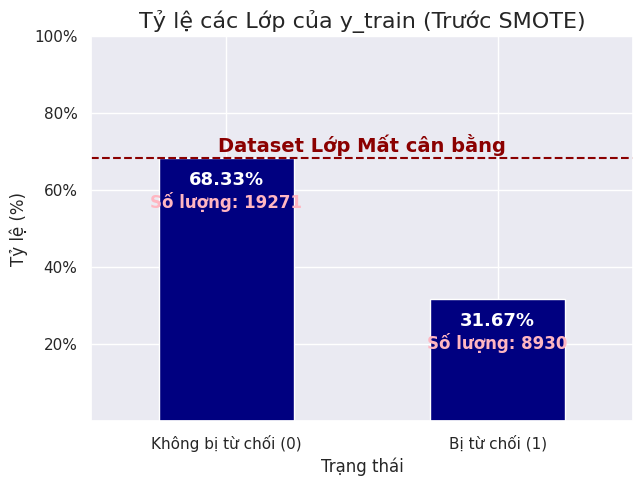

Phân phối y_train (TRƯỚC SMOTE):
rejected
0    19271
1     8930
Name: count, dtype: int64

Tỷ lệ %:
rejected
0    68.334456
1    31.665544
Name: proportion, dtype: float64


In [39]:
# ==============================================================
# 6.b.i. KIỂM TRA IMBALANCE TRONG TRAIN SET
# ==============================================================

# Vẽ biểu đồ phân phối target trong train set (TRƯỚC SMOTE)
fig, ax = plt.subplots(figsize=(7, 5))

# Tính tỷ lệ % của 2 classes (0 và 1)
plot_dataseries = round(y_train.value_counts(normalize=True) * 100, 2)

# Vẽ biểu đồ cột
plot_dataseries.plot(kind="bar", ax=ax, color="navy")

# Thêm text cảnh báo
plt.text(0.5, 70, "Dataset Lớp Mất cân bằng", color="darkred",
         horizontalalignment="center", fontsize=14, fontweight=700)
plt.axhline(y=plot_dataseries[0], color="darkred", linestyle="--")

# Tiêu đề và nhãn
plt.title("Tỷ lệ các Lớp của y_train (Trước SMOTE)", fontsize=16)
plt.ylabel("Tỷ lệ (%)", fontsize=12)
plt.xlabel("Trạng thái", fontsize=12)
plt.xticks(ticks=range(len(plot_dataseries)),
           labels=["Không bị từ chối (0)", "Bị từ chối (1)"], 
           rotation="horizontal")
plt.yticks(ticks=[20, 40, 60, 80, 100], labels=["20%", "40%", "60%", "80%", "100%"])

# Thêm nhãn % lên cột
data_label = plot_dataseries.astype(str). str.cat(np.full((2,), "%"), sep="")
for x, y in enumerate(plot_dataseries):
    plt. text(x, y-7, data_label[x], color="white",
             fontweight=700, fontsize=13, horizontalalignment="center")

# Thêm nhãn số đếm (Count)
for x, y in enumerate(y_train. value_counts()):
    plt.text(x, plot_dataseries[x]-13, 
             f"Số lượng: {y_train.value_counts()[x]}",
             horizontalalignment="center", color="lightpink", 
             fontsize=12, fontweight=700)

plt.show()

# In kết quả ra console
print("Phân phối y_train (TRƯỚC SMOTE):")
print(y_train.value_counts())
print("\nTỷ lệ %:")
print(y_train.value_counts(normalize=True) * 100)

### **6.b.ii.  Áp dụng SMOTE để cân bằng train set**

**Mục đích:** Sử dụng SMOTENC để tạo synthetic samples cho minority class, đạt tỷ lệ 50-50

**SMOTE hoạt động như thế nào:**

SMOTE tạo synthetic samples mới bằng cách nội suy (interpolate) giữa các minority samples hiện có.  Cụ thể: 
(1) Chọn một minority sample, (2) Tìm k nearest neighbors của nó, (3) Chọn ngẫu nhiên một neighbor, (4) Tạo synthetic sample nằm trên đoạn thẳng nối giữa sample gốc và neighbor đó.  Điều này giúp model học được vùng decision boundary tốt hơn thay vì chỉ "ghi nhớ" các samples bị duplicate. 

In [40]:
from imblearn.over_sampling import SMOTENC

print(" ÁP DỤNG SMOTENC (SMOTE for Mixed Categorical + Numerical Data)")
print()

# BƯỚC 1: XÁC ĐỊNH CATEGORICAL FEATURES
# SMOTENC cần biết cột nào là categorical để xử lý đúng
# → Lấy index (vị trí) của các cột categorical (dtype='object')

categorical_features = []
for i, col in enumerate(X_train.columns):
    if X_train[col].  dtype == 'object':
        categorical_features.append(i)

print("Thông tin về features:")
print(f"   → Tổng số features: {len(X_train. columns)}")
print(f"   → Categorical feature indices: {categorical_features}")
print(f"   → Categorical features: {[X_train.columns[i] for i in categorical_features]}")
print(f"   → Numerical features: {list(X_train.select_dtypes(exclude='object').columns)}")
print()

# BƯỚC 2: KHỞI TẠO SMOTENC
#  Tạo SMOTENC instance
smote = SMOTENC(
    categorical_features=categorical_features,  # Chỉ định cột nào là categorical
    random_state=42,  # Để reproducible (chạy lại ra kết quả giống nhau)
    k_neighbors=5  # Số neighbors dùng để tạo synthetic samples
)
print(" SMOTENC Parameters:")
print(f"   → k_neighbors: 5 (mỗi synthetic sample tạo từ 5 neighbors gần nhất)")
print(f"   → random_state: 42 (đảm bảo reproducibility)")
print()
# BƯỚC 3: FIT-RESAMPLE (Chỉ trên TRAIN SET!)

print(" Đang áp dụng SMOTE trên train set...")
print(f"   → Train set TRƯỚC SMOTE: {X_train.  shape}")
print(f"   → y_train TRƯỚC SMOTE: {y_train.value_counts(). to_dict()}")
print()

#  Fit và resample
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print(" SMOTE hoàn thành!")
print(f"   → Train set SAU SMOTE: {X_train_over.shape}")
print(f"   → y_train SAU SMOTE: {y_train_over.value_counts().to_dict()}")
print()

# BƯỚC 4: KIỂM TRA KẾT QUẢ

print(" Phân phối class sau SMOTE:")
print(y_train_over.value_counts())
print("\nTỷ lệ %:")
print(y_train_over.value_counts(normalize=True) * 100)
print()

# Kiểm tra cân bằng
class_0_pct = y_train_over. value_counts(normalize=True)[0] * 100
class_1_pct = y_train_over. value_counts(normalize=True)[1] * 100

if abs(class_0_pct - 50) < 0.1 and abs(class_1_pct - 50) < 0.1:
    print("Perfect balance: 50-50!")
else:
    print(f" Balance: {class_0_pct:.2f}% - {class_1_pct:. 2f}%")

print()
print(" TRAIN SET ĐÃ ĐƯỢC CÂN BẰNG!")

 ÁP DỤNG SMOTENC (SMOTE for Mixed Categorical + Numerical Data)

Thông tin về features:
   → Tổng số features: 9
   → Categorical feature indices: [0, 1, 2, 3, 5, 8]
   → Categorical features: ['fulfilment', 'shipservicelevel', 'category', 'size', 'b2b', 'region']
   → Numerical features: ['amount', 'is_qty_suspicious', 'amount_log']

 SMOTENC Parameters:
   → k_neighbors: 5 (mỗi synthetic sample tạo từ 5 neighbors gần nhất)
   → random_state: 42 (đảm bảo reproducibility)

 Đang áp dụng SMOTE trên train set...
   → Train set TRƯỚC SMOTE: (28201, 9)
   → y_train TRƯỚC SMOTE: {0: 19271, 1: 8930}

 SMOTE hoàn thành!
   → Train set SAU SMOTE: (38542, 9)
   → y_train SAU SMOTE: {1: 19271, 0: 19271}

 Phân phối class sau SMOTE:
rejected
1    19271
0    19271
Name: count, dtype: int64

Tỷ lệ %:
rejected
1    50.0
0    50.0
Name: proportion, dtype: float64

Perfect balance: 50-50!

 TRAIN SET ĐÃ ĐƯỢC CÂN BẰNG!


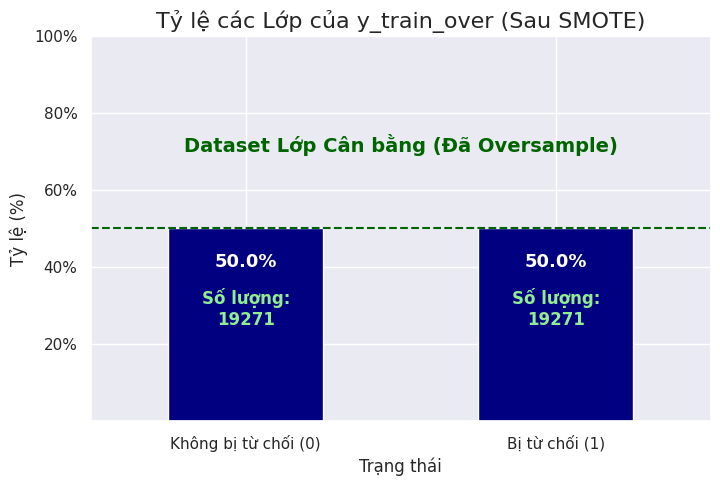


 Biểu đồ đã hoàn thành!


In [41]:
# ==============================================================
# VẼ BIỂU ĐỒ: TRAIN SET SAU KHI ÁP DỤNG SMOTE
# ==============================================================

fig, ax = plt.subplots(figsize=(8, 5))

# Tính tỷ lệ % của y_train_over (sau SMOTE)
plot_dataseries = round(y_train_over.value_counts(normalize=True) * 100, 2)

# Vẽ biểu đồ cột
plot_dataseries.plot(kind="bar", ax=ax, color="navy")

# Thêm text xác nhận cân bằng
plt.text(0.5, 70, "Dataset Lớp Cân bằng (Đã Oversample)", color="darkgreen",
         horizontalalignment="center", fontsize=14, fontweight=700)
plt.axhline(y=plot_dataseries[0], color="darkgreen", linestyle="--")

# Tiêu đề và nhãn
plt.title("Tỷ lệ các Lớp của y_train_over (Sau SMOTE)", fontsize=16)
plt.ylabel("Tỷ lệ (%)", fontsize=12)
plt.xlabel("Trạng thái", fontsize=12)
plt.xticks(ticks=range(len(plot_dataseries)),
           labels=["Không bị từ chối (0)", "Bị từ chối (1)"],
           rotation="horizontal")
plt.yticks(ticks=[20, 40, 60, 80, 100], labels=["20%", "40%", "60%", "80%", "100%"])

# Thêm nhãn % lên cột
data_label = plot_dataseries.astype(str). str.cat(np.full((2,), "%"), sep="")
for x, y in enumerate(plot_dataseries):
    plt.text(x, y-10, data_label[x], color="white",
             fontweight=700, fontsize=13, horizontalalignment="center")

# Thêm nhãn số đếm
for x, y in enumerate(y_train_over.value_counts()):
    plt.text(x, plot_dataseries[x]-25,
             f"Số lượng:\n{y_train_over. value_counts()[x]}",
             horizontalalignment="center", color="lightgreen", fontweight=700)

plt.show()

print("\n Biểu đồ đã hoàn thành!")

#### **KẾT QUẢ SAU KHI ÁP DỤNG SMOTE:**

**Train set đã được cân bằng:**
- **Trước SMOTE:** ~58% class 0, ~42% class 1 (lệch)
- **Sau SMOTE:** 50% class 0, 50% class 1 (cân bằng hoàn hảo)

**Lợi ích:**
1. **Giảm bias:** Model không bị thiên vị về class đa số
2. **Cải thiện Recall:** Model học được minority class tốt hơn
3. **Synthetic samples:** SMOTE tạo samples mới (không duplicate) → tránh overfitting
4. **Preserve test set:** Test set giữ nguyên distribution gốc → đánh giá công bằng


### **6.c. Data Transformation (Pipelines)**

**Mục đích:** 
- Xử lý NaN (nếu còn)
- Scale numerical features
- Encode categorical features

**Phương pháp: Sklearn Pipelines + ColumnTransformer**

Sklearn pipelines cho phép gói tất cả preprocessing steps vào một object duy nhất, đảm bảo cùng transformations được áp dụng đồng nhất cho train và test data (tránh data leakage).  ColumnTransformer cho phép áp dụng transforms khác nhau cho từng loại cột (numerical vs categorical).

### <br>**6.c.ii.** NUMERICAL PIPELINE.

In [42]:
from sklearn.preprocessing import StandardScaler

# Tạo pipeline: Điền giá trị thiếu bằng trung vị -> Chuẩn hóa
num_transformer = make_pipeline(
    SimpleImputer(strategy='median'),  # Trung vị ít bị ảnh hưởng bởi ngoại lai hơn trung bình
    StandardScaler()  # Công thức: (x - trung bình) / độ lệch chuẩn
)

print("✅ Numerical transformer pipeline created:")
num_transformer

✅ Numerical transformer pipeline created:


Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

### <br>**6.c.ii.** CATEGORICAL PIPELINE.

In [43]:
# Pipeline: SimpleImputer (điền NaN) → OneHotEncoder (encode)
# - SimpleImputer với strategy='most_frequent': Điền bằng mode
# - OneHotEncoder với drop='first': Tránh dummy variable trap

cat_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),  # Điền NaN bằng mode
    OneHotEncoder(drop="first", handle_unknown='ignore')  # OneHot encode
)

print(" Categorical transformer created:")
print(cat_transformer)

 Categorical transformer created:
Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(drop='first', handle_unknown='ignore'))])


### <br>**6.c.iii.** iii. ColumnTransformer (Bộ biến đổi cột) để chạy song song.


In [44]:
# Cập nhật bộ biến đổi dữ liệu phân loại để xử lý các danh mục chưa xuất hiện
cat_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(drop="first", handle_unknown='ignore')  # Thêm tham số xử lý giá trị lạ
)

# Khởi tạo ColumnTransformer
col_transformer = ColumnTransformer([
    ("numtransformer", num_transformer,
     X_train_over.select_dtypes(exclude="object").columns),
    ("cattransformer", cat_transformer,
     X_train_over.select_dtypes(include="object").columns)
], remainder='drop')  # Loại bỏ các cột còn lại không được liệt kê

print("Column transformer created!")
print(f"\nNumerical features: {list(X_train_over.select_dtypes(exclude='object').columns)}")
print(f"Categorical features: {list(X_train_over.select_dtypes(include='object').columns)}")

col_transformer

Column transformer created!

Numerical features: ['amount', 'is_qty_suspicious', 'amount_log']
Categorical features: ['fulfilment', 'shipservicelevel', 'category', 'size', 'b2b', 'region']


ColumnTransformer(transformers=[('numtransformer',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['amount', 'is_qty_suspicious', 'amount_log'], dtype='object')),
                                ('cattransformer',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 Index(['fulfilment', 'shipservicelevel', 'category', 'size', 'b2b', 'region'], dtype='object'))])

<a id = "models"></a>
# **7. CLASSIFICATION MODELS FOR PREDICTION**
